## Model Assumptions
* Once Recovered can't be infected again. Recovered and Death cases are simply removed from population.
* An airplane carries 115 passengers on average
* Number of people getting into a country is estimated as 

$$incomingPeople=incomingRoutes \cdot log_{10}~countryPopulation $$

* Number of people getting out of a country is estimated as 

$$outgoingPeople=outgoingRoutes \cdot log_{10}~countryPopulation $$

     This will be fractured for each compartment (S, I, R)


#### Useful notes
* beta and gamma can be selected from rates determined from prior outbreaks, but they often vary for different outbreaks of the same disease
* __To estimate beta and gamma from data__: if beta=0.29/day, the time it takes to double the number of infected people is about 1/0.29 = 3.4 days, hence, beta=1/days it takes to double infections. Similarly, gamma=0.15 implies that is takes 1/0.15=6.7 days to recover/die, hence, gamma=1/days it takes to recover/die.


In [138]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import networkx as nx
from datetime import datetime as dt, date, timedelta
from math import log

%matplotlib inline

In [139]:
# Load Graph
g_data = json.load(open("data/graph_to_load_in_nx.json", "r"))
g = nx.DiGraph()
g.add_weighted_edges_from(g_data)
countries = list(g.nodes)

In [140]:
# Load country coordinates and attach to nodes
countries_coords = pd.read_csv("data/country_centroids_az8.csv")
countries_coords = countries_coords[['name', 'Longitude', 'Latitude']]
countries_coords.replace(["Macao", "Korea"], ["Macau", "South Korea"], inplace=True)
countries_coords.index = countries_coords.name
countries_coords.loc['France', 'Longitude'] = 2.2137
countries_coords.loc['France', 'Latitude'] = 46.2276
countries_coords = countries_coords[countries_coords.name.isin(countries)][['Longitude', 'Latitude']]
coords_dict = countries_coords.to_dict(orient='index')
nx.set_node_attributes(g, coords_dict)

In [141]:
# Load Population data and attach to nodes
countries_population_data = pd.read_csv("data/countries_population_data.csv", index_col=0)
for c in countries:
    pop = countries_population_data[countries_population_data['Country'] == c]['Pop 2018'].values[0]
    nx.set_node_attributes(g, {c: {'Population': pop}})
    

In [142]:
# Load and clean COVID-19 data
confirmed = pd.read_csv("data/time_series_covid19_confirmed_global.csv")
confirmed.loc[61, 'Country/Region'] = "Hong Kong"  #Hong Kong as its own country
confirmed.loc[69, 'Country/Region'] = "Macau"  #Hong Kong as its own country
confirmed.replace(["Taiwan*", "Korea, South", "US"], ["Taiwan", "South Korea", "United States"], inplace=True)
confirmed = confirmed.groupby('Country/Region').sum()  #Group regions by country
confirmed = confirmed[confirmed.index.isin(countries)]
confirmed.drop(["Lat", "Long"], axis=1, inplace=True)
assert len(set(countries).difference(confirmed.index.values.tolist())) == 0

recovered = pd.read_csv("data/time_series_covid19_recovered_global.csv")
recovered.loc[52, 'Country/Region'] = "Hong Kong"  #Hong Kong as its own country
recovered.loc[60, 'Country/Region'] = "Macau"  #Hong Kong as its own country
recovered.replace(["Taiwan*", "Korea, South", "US"], ["Taiwan", "South Korea", "United States"], inplace=True)
recovered = recovered.groupby('Country/Region').sum()  #Group regions by country
recovered = recovered[recovered.index.isin(countries)]
recovered.drop(["Lat", "Long"], axis=1, inplace=True)
assert len(set(countries).difference(recovered.index.values.tolist())) == 0

deaths = pd.read_csv("data/time_series_covid19_deaths_global.csv")
deaths.loc[61, 'Country/Region'] = "Hong Kong"  #Hong Kong as its own country
deaths.loc[69, 'Country/Region'] = "Macau"  #Hong Kong as its own country
deaths.replace(["Taiwan*", "Korea, South", "US"], ["Taiwan", "South Korea", "United States"], inplace=True)
deaths = deaths.groupby('Country/Region').sum()  #Group regions by country
deaths = deaths[deaths.index.isin(countries)]
deaths.drop(["Lat", "Long"], axis=1, inplace=True)
assert len(set(countries).difference(deaths.index.values.tolist())) == 0

np.testing.assert_array_equal(confirmed.index.values, recovered.index.values, deaths.index.values)


In [143]:
# Define function to estimate Beta and Gamma given COVID-19 data
def getEstimatedBetaGamma(country, initial_pop, confirmed, recovered, deaths, T, verbose=True):
       
        first_confirmed_case = confirmed[confirmed.index == country].iloc[0].ne(0).idxmax()
        country_confirmed = confirmed[confirmed.index == country].loc[country, first_confirmed_case:].values
        I_0 = country_confirmed[0]

        country_recovered = recovered[recovered.index == country].loc[country, first_confirmed_case:].values
        R_0 = country_recovered[0]

        country_deaths = deaths[deaths.index == country].loc[country, first_confirmed_case:].values
        
        if verbose:
            print("{}'s first confirmed cases date: {} with {} infected and {} recovered.".format(
                country, first_confirmed_case, I_0, R_0
            ))

        S = [ initial_pop ]
        I = [ I_0 ]
        R = [ R_0 ]
        for t in range(1, len(country_confirmed)-1):
            
            S_t = S[t-1] - (country_confirmed[t] + country_recovered[t] + country_deaths[t])
            S.append(S_t)
            I_t = country_confirmed[t]
            I.append(I_t)
            R_t = country_recovered[t] + country_deaths[t]
            R.append(R_t)


        confirmed_doubled_intervals = []
        for i0 in range(len(I)):
            for i1 in range(len(I)):
                if I[i1] >= I[i0]*2:
                    confirmed_doubled_intervals.append(i1 - i0)
                    break

        country_betas = np.array([1/n if n>0 else 0 for n in confirmed_doubled_intervals])
        #print(country_betas)
        if verbose:
            print("{}'s average beta: {}".format(country, country_betas.mean().round(5)))

        confirmed_to_recovered_or_died_intervals = []
        for i in range(len(country_confirmed)):
            infected = country_confirmed[i]
            for j in range(len(country_confirmed)):
                recovered = country_recovered[j]
                deaths = country_deaths[j]
                if (recovered+deaths) >= infected:
                    confirmed_to_recovered_or_died_intervals.append(j-i)
                    break

        country_gammas = np.array([1/n if n>0 else 0 for n in confirmed_to_recovered_or_died_intervals])
        if verbose:
            print("{}'s average gamma: {}".format(country, country_gammas.mean().round(5)))

        return country_betas.mean(), country_gammas.mean()

In [144]:
# Estimate beta and gamma for each country and attach to node

T = 350  # Simulation number of days 

affected_countries_population = 0

country_populations = nx.get_node_attributes(g, "Population")
for c in countries:
    affected_countries_population += country_populations[c]
    beta, gamma = getEstimatedBetaGamma(c, country_populations[c], confirmed, recovered, deaths, T, verbose=False)
    nx.set_node_attributes(g, {c: {"Beta": beta, 'Gamma': gamma}})

## Simulation with no restrictions

In [150]:
# Simulation
country_betas = nx.get_node_attributes(g, "Beta")
country_gammas = nx.get_node_attributes(g, "Gamma")

# Precompute outbound routes for each country
out_routes = {}
for country in countries:
    outgoing_routes = sum([g.get_edge_data(country, i)["weight"] for i in g.neighbors(country)])
    out_routes[country] = outgoing_routes

S_lists = {}
I_lists = {}
R_lists = {}

# Initialise lists values
for c in countries:
    S_lists[c] = [ country_populations[c] ]
    I_lists[c] = [ confirmed.loc[c, confirmed.columns[0]] ]
    R_lists[c] = [ deaths.loc[c, deaths.columns[0]] ]
    
# Carry out simulation
for t in range(1, T):
    for c in countries:
        # Get people coming into the country for each compartment
        S_in_t = 0
        I_in_t = 0
        R_in_t = 0
        total_in = 0
        for n in g.nodes():
            if g.get_edge_data(n, c) is not None:
                n_in_route = g.get_edge_data(n, c)['weight'] 
                n_total_pop = S_lists[n][t-1] + I_lists[n][t-1] + R_lists[n][t-1]
                n_in_population = n_in_route * np.log10(n_total_pop)
                total_in += n_in_population
                S_in_t += (S_lists[n][t-1] / n_total_pop) * n_in_population
                I_in_t += (I_lists[n][t-1] / n_total_pop) * n_in_population
                R_in_t += (R_lists[n][t-1] / n_total_pop) * n_in_population
        # Get people going out of the country for each compartment
        current_population = S_lists[c][t-1] + I_lists[c][t-1] + R_lists[c][t-1]
        out_population = out_routes[c] * np.log10(current_population)
 
        S_out_t = (S_lists[c][t-1] / current_population) * out_population
        I_out_t = (I_lists[c][t-1] / current_population) * out_population
        R_out_t = (R_lists[c][t-1] / current_population) * out_population

        S_t = S_lists[c][t-1] - ((S_lists[c][t-1] / S_lists[c][0]) * (country_betas[c]*I_lists[c][t-1]))
        S_lists[c].append(S_t - S_out_t + S_in_t)
        
        I_t = I_lists[c][t-1] + ((S_lists[c][t-1] / S_lists[c][0]) * (country_betas[c]*I_lists[c][t-1])) - (I_lists[c][t-1] * country_gammas[c])
        I_lists[c].append(I_t - I_out_t + I_in_t)
        
        R_t = R_lists[c][t-1] + (I_lists[c][t-1] * country_gammas[c])
        R_lists[c].append(R_t - R_out_t + R_in_t)
        
      

South Korea


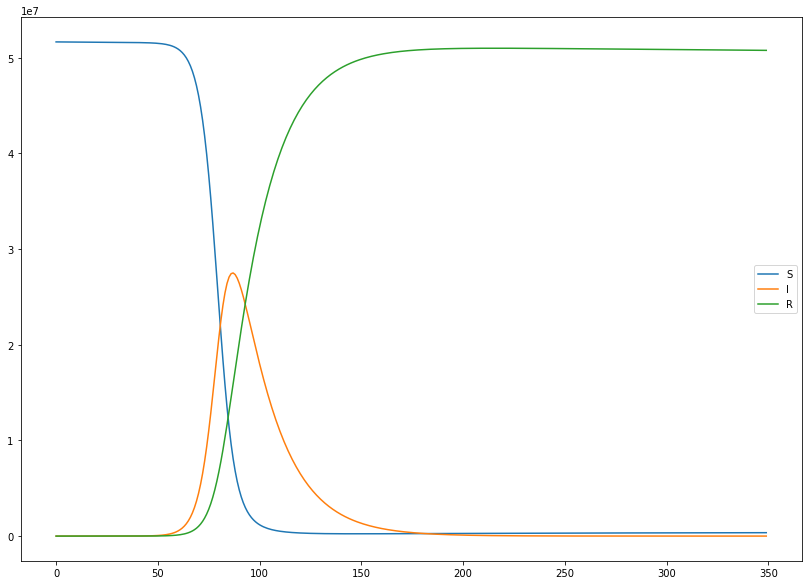

Israel


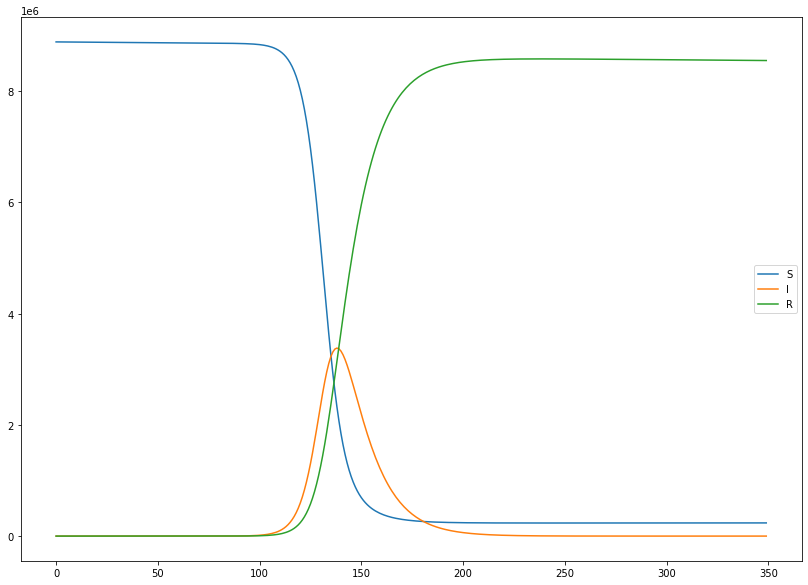

Philippines


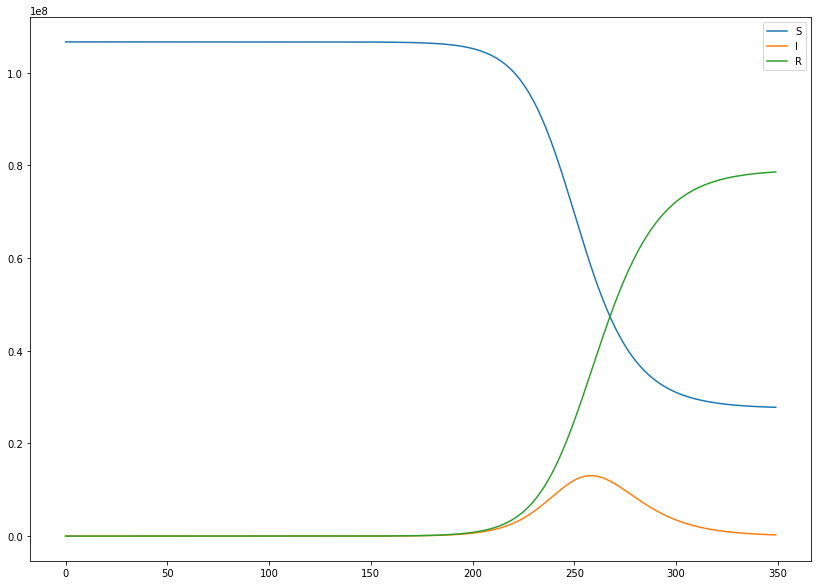

United States


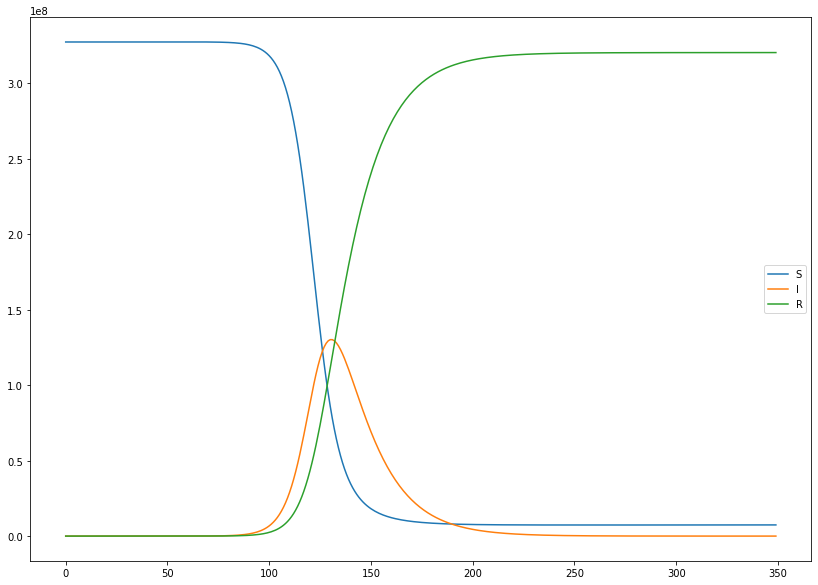

United Kingdom


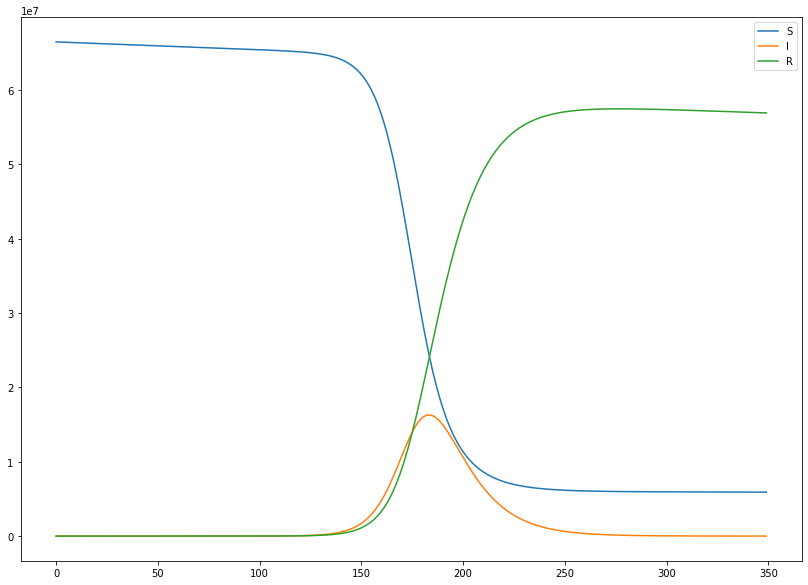

Singapore


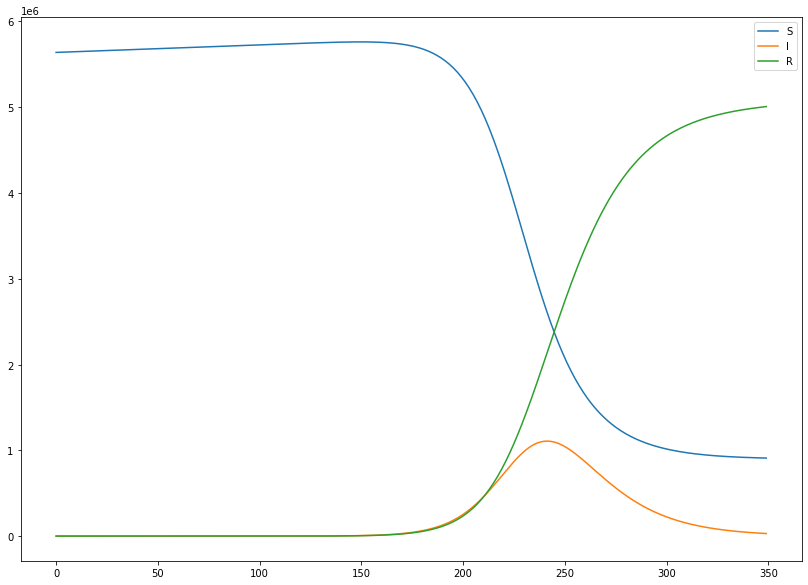

Sweden


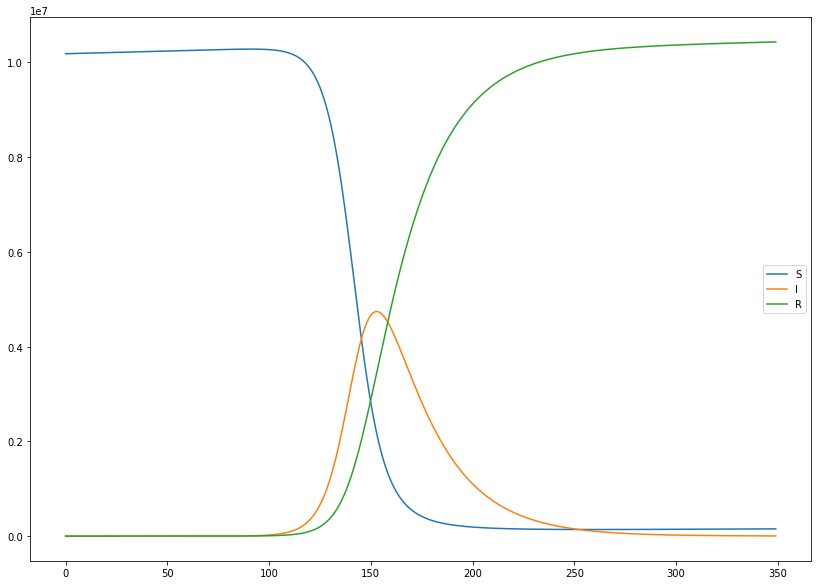

Italy


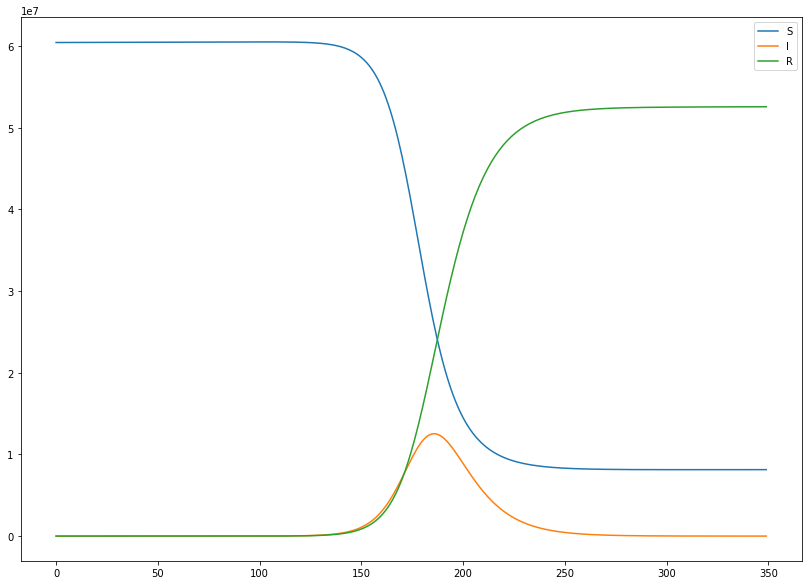

France


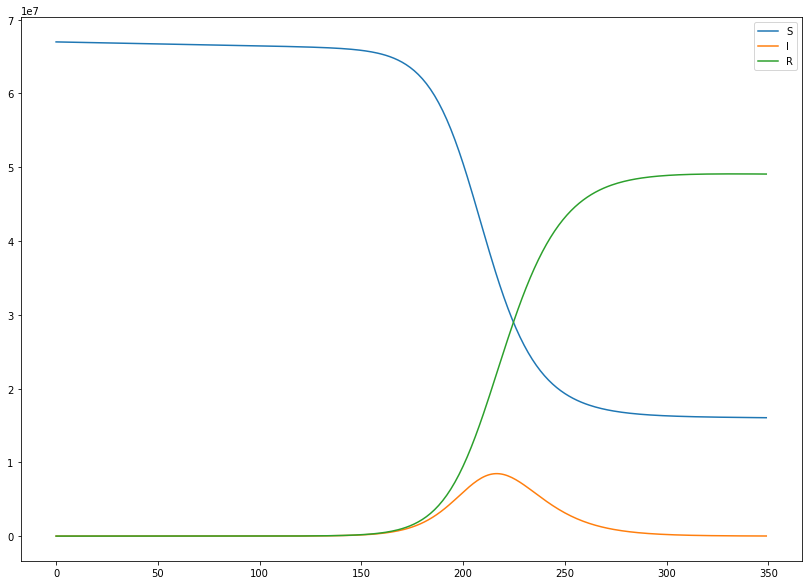

Finland


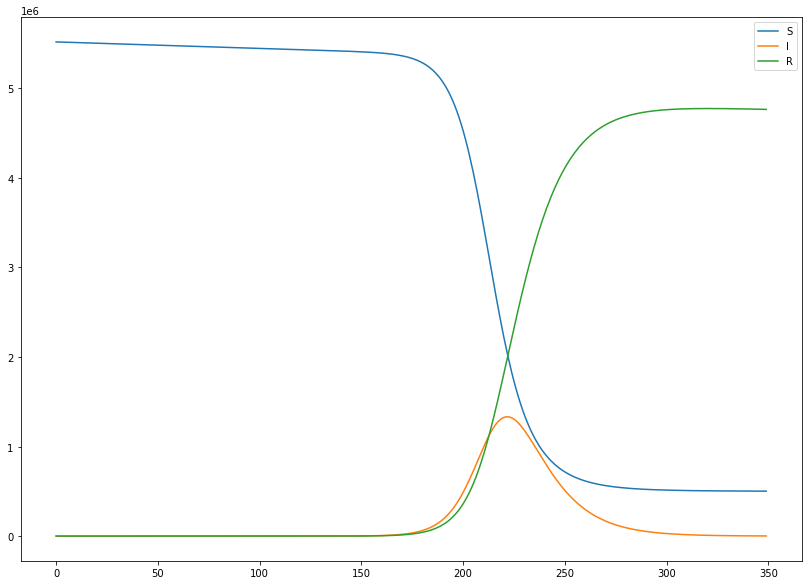

Vietnam


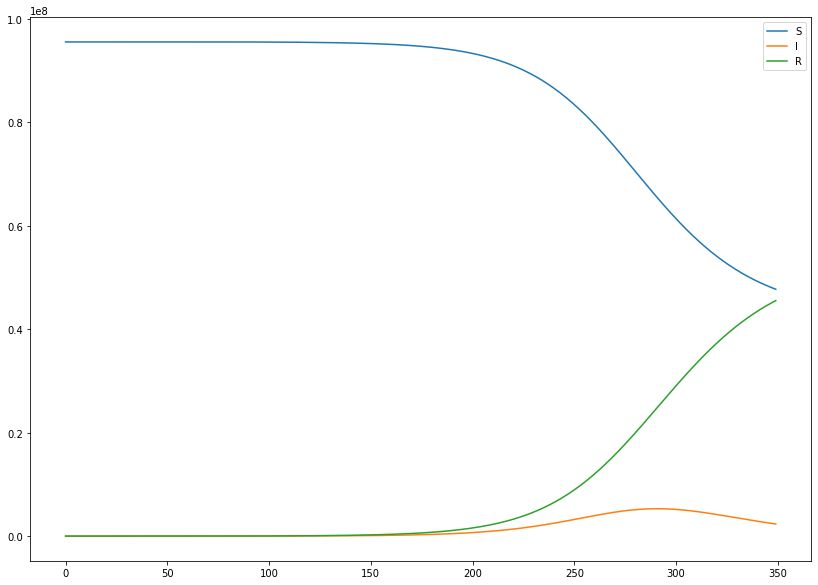

Russia


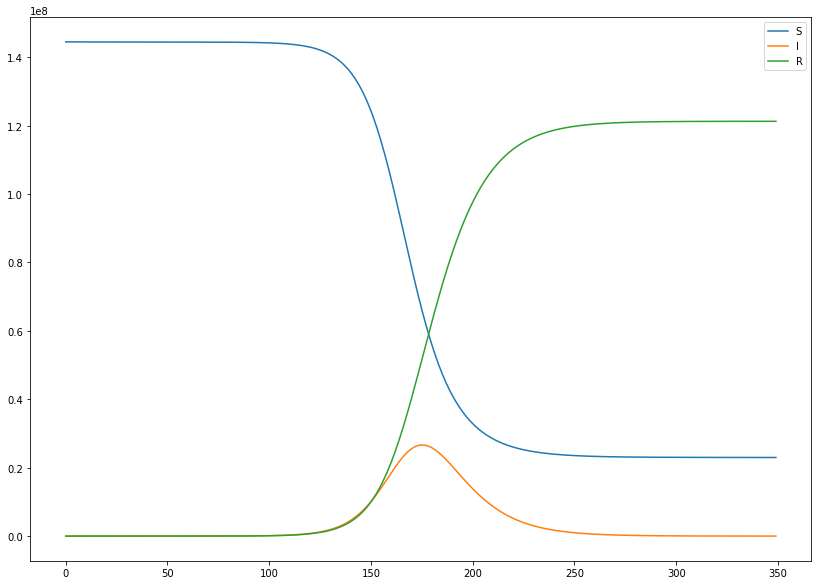

Macau


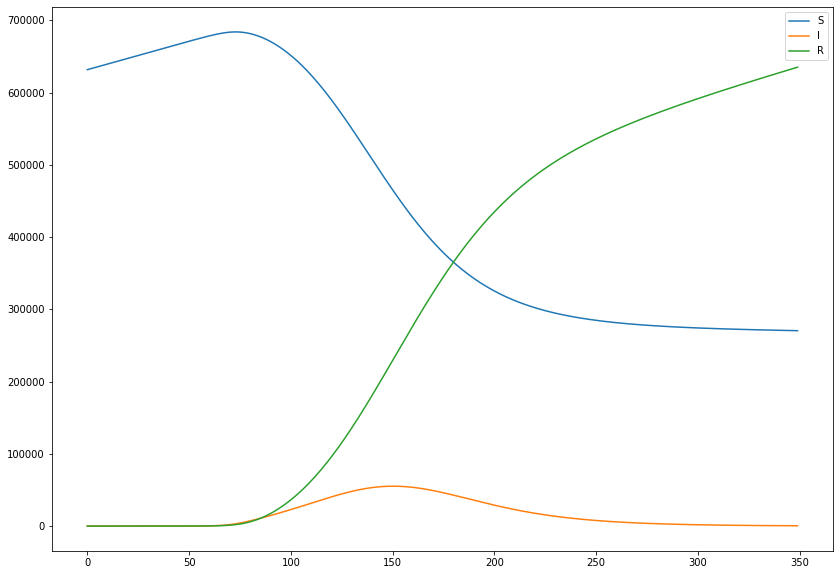

Taiwan


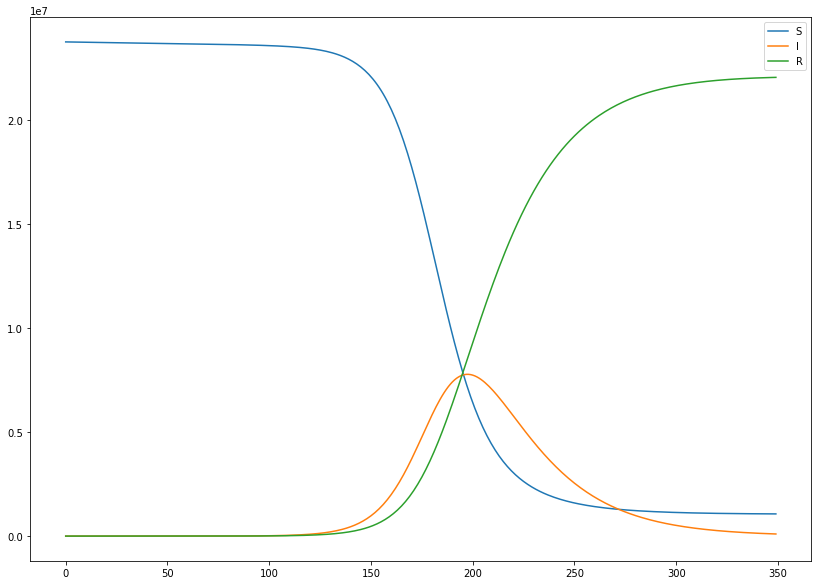

Japan


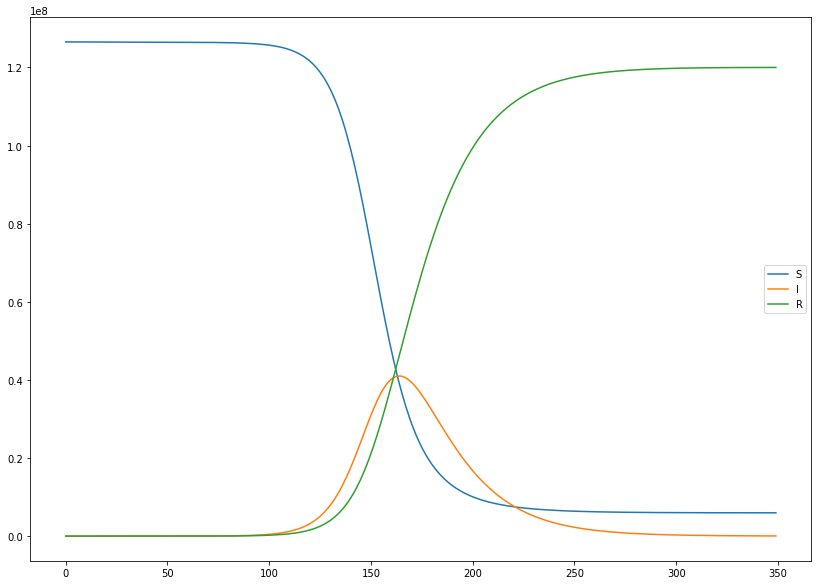

Malaysia


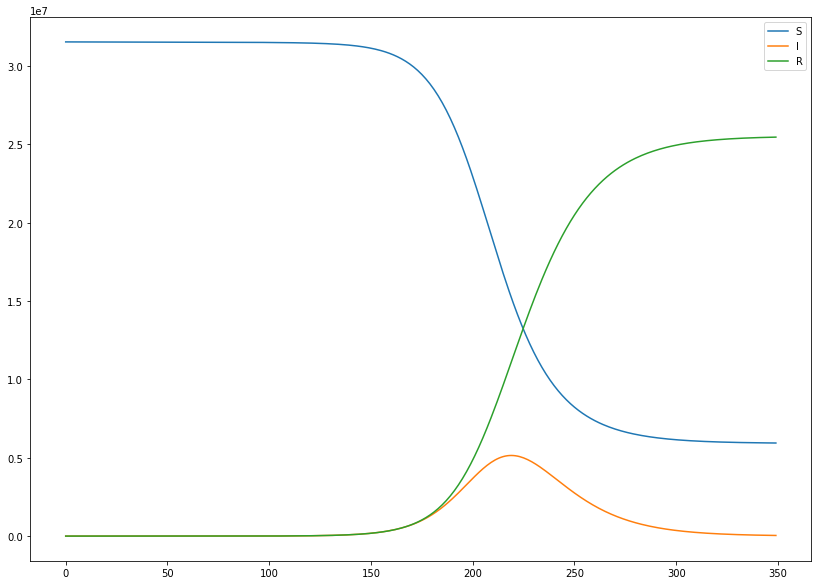

Thailand


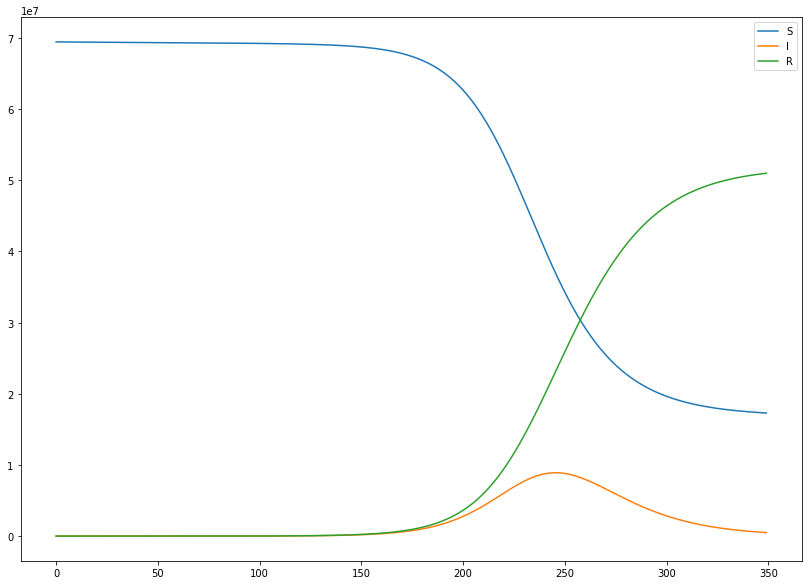

Germany


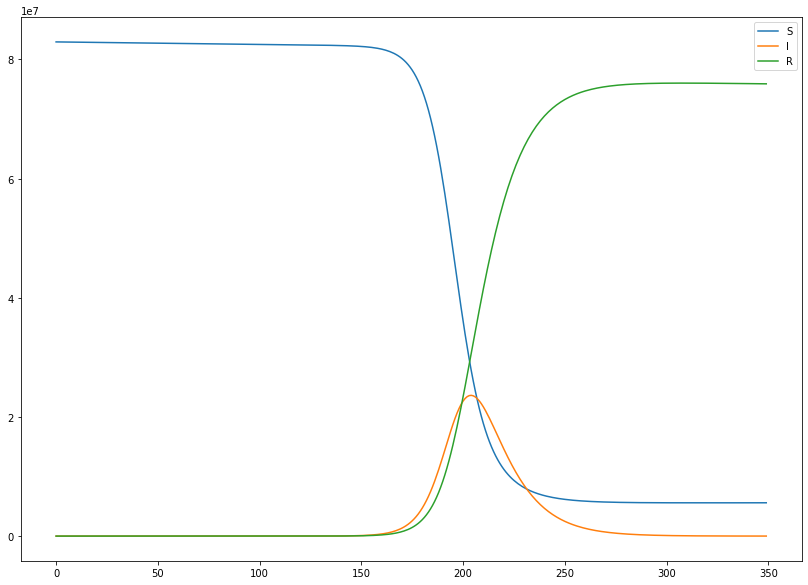

Australia


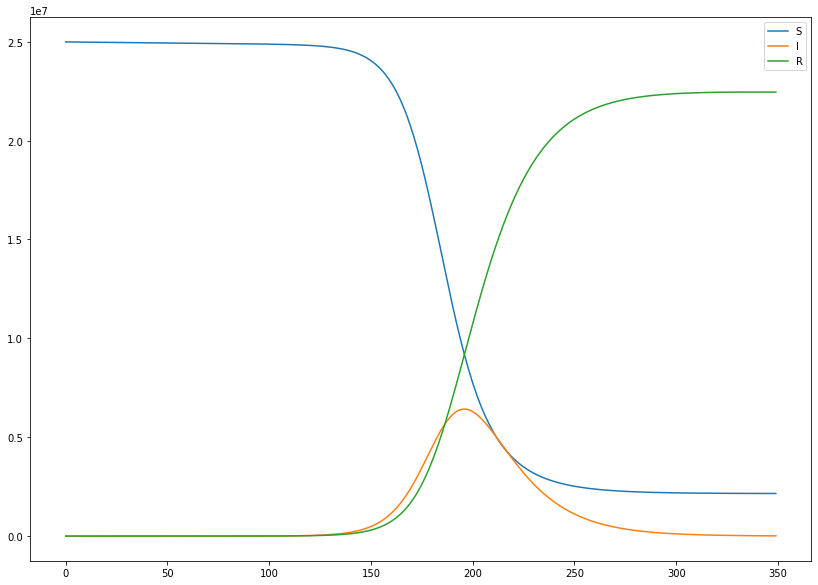

United Arab Emirates


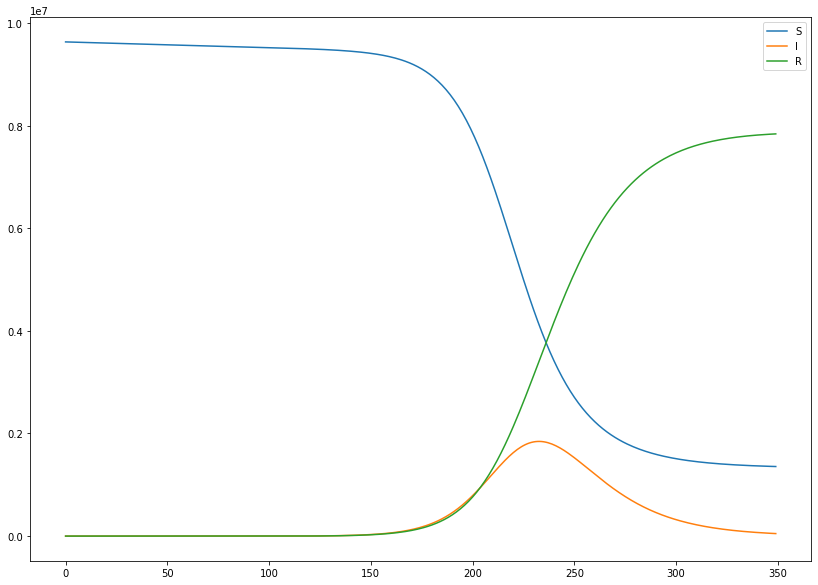

Canada


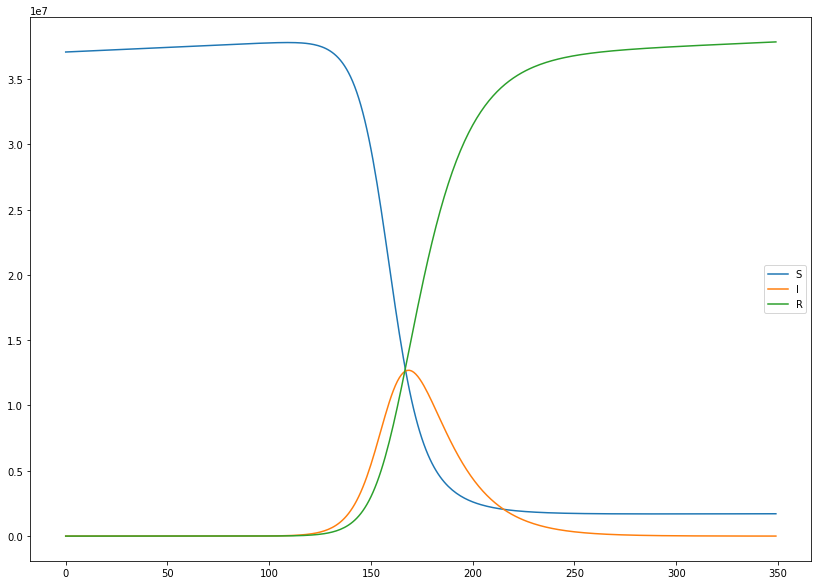

Bahrain


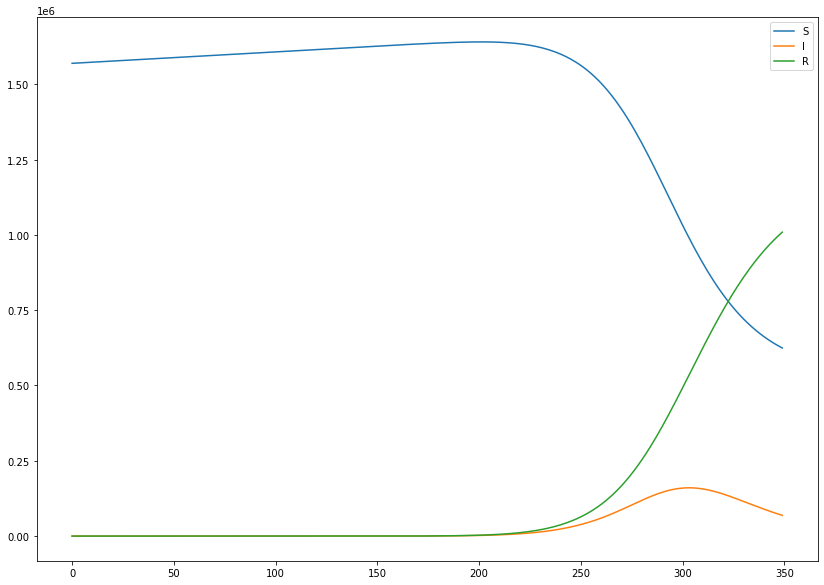

Iran


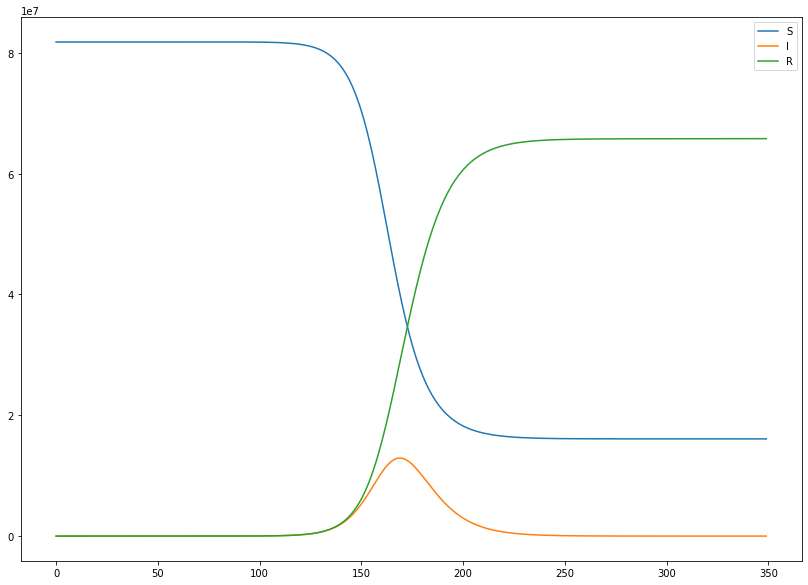

Belgium


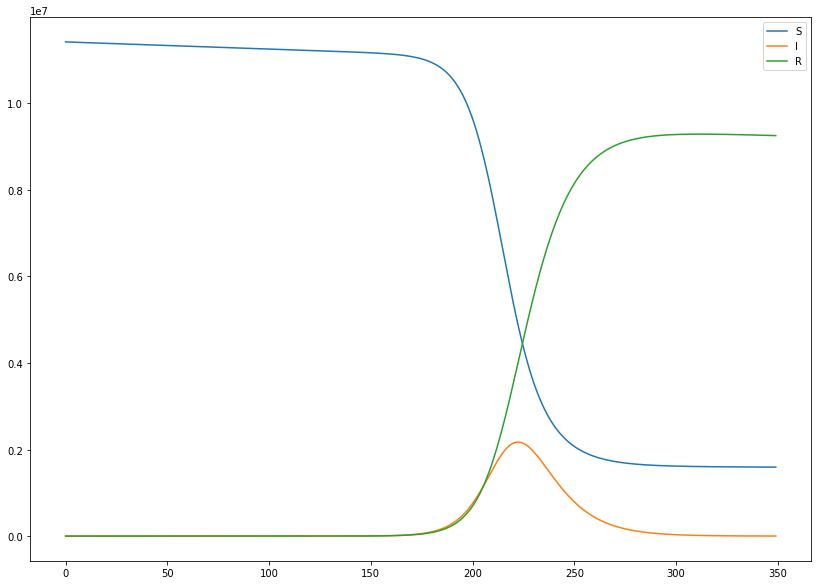

China


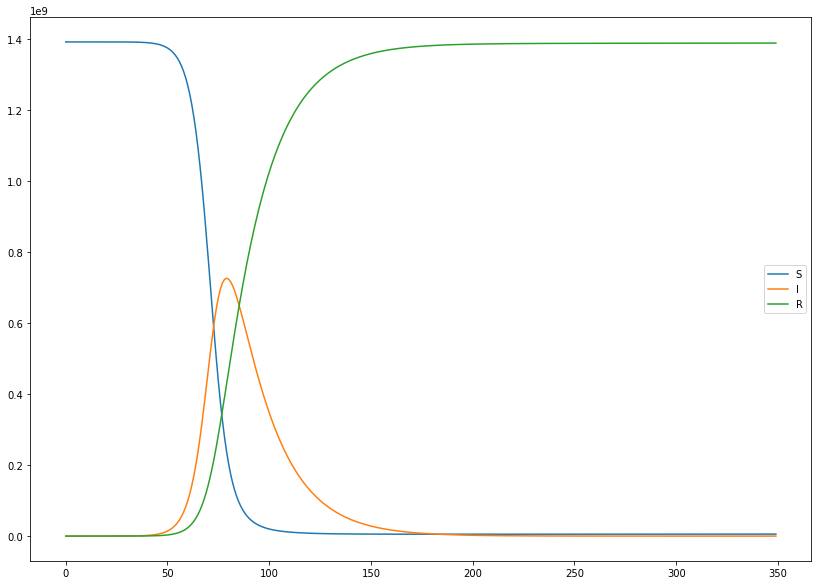

Spain


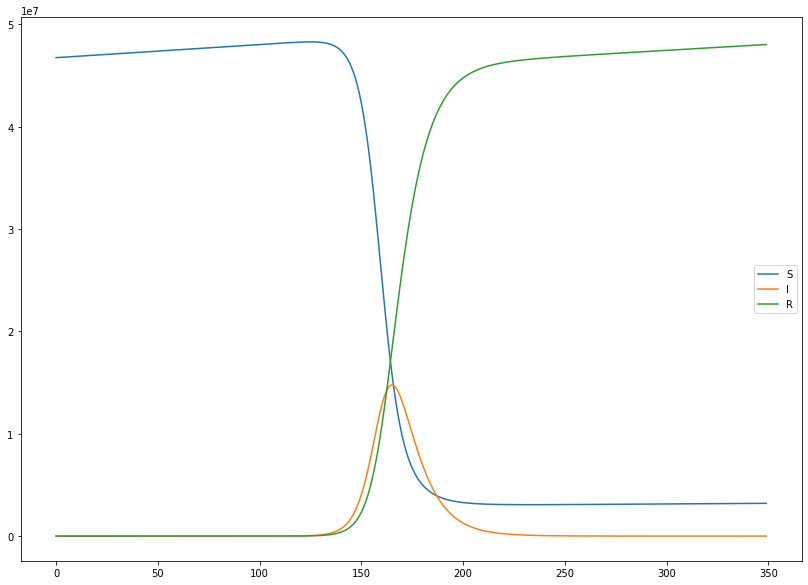

Hong Kong


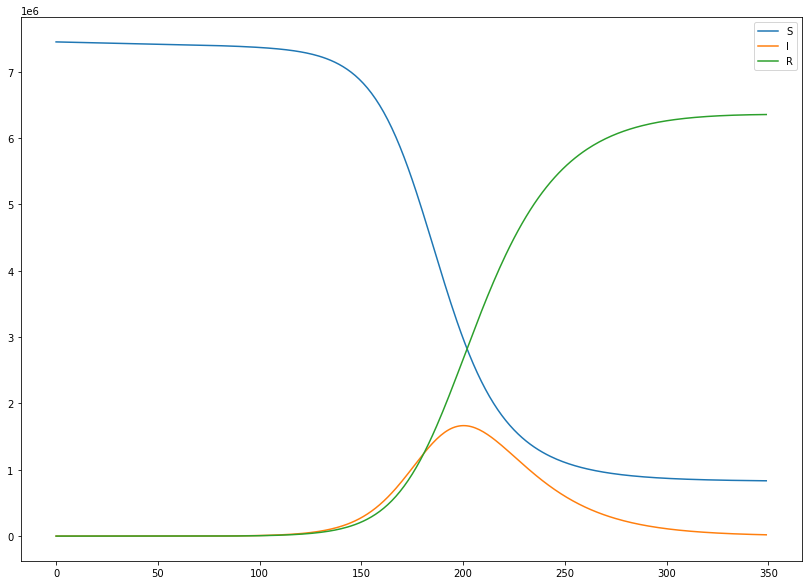

Sri Lanka


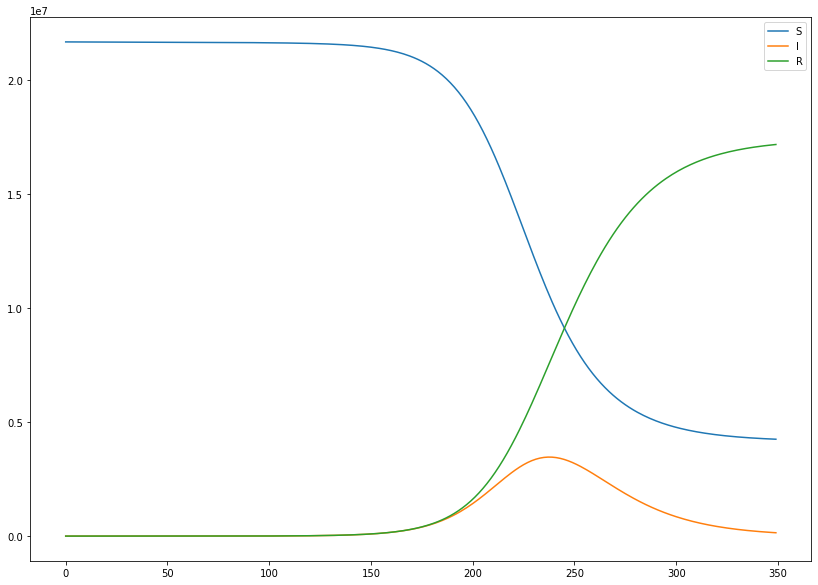

Kuwait


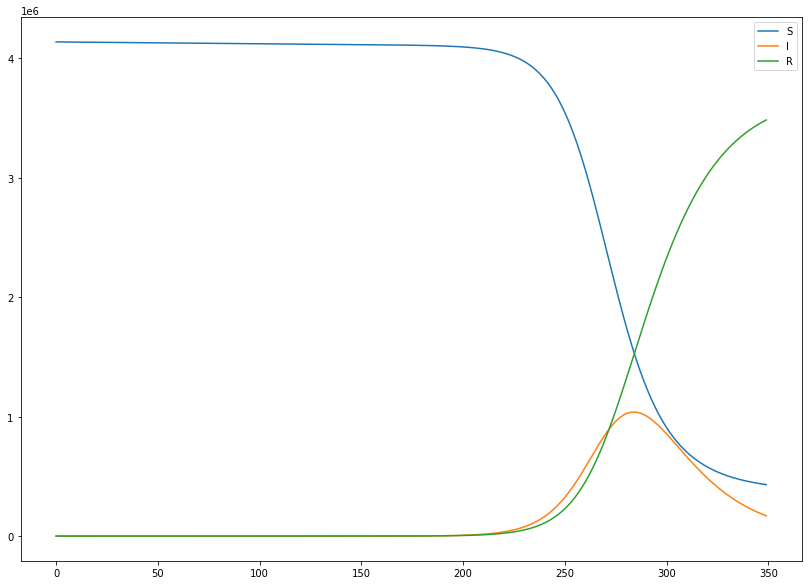

Oman


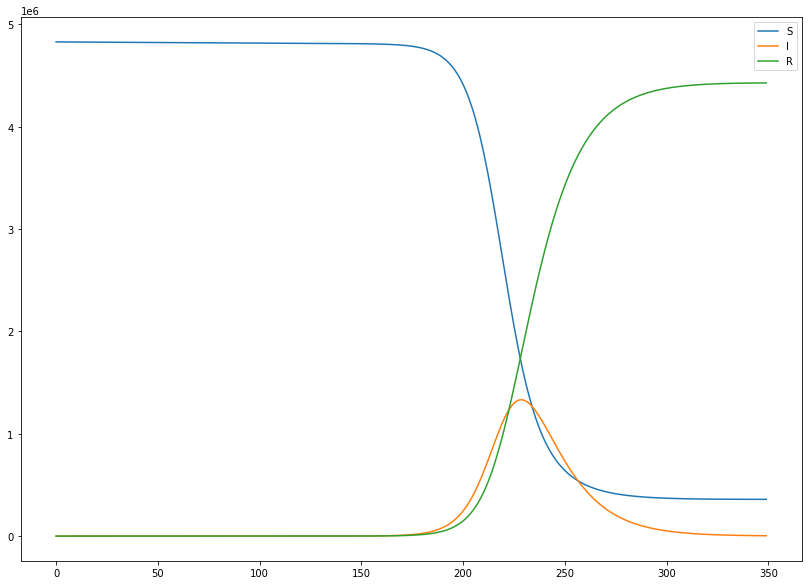

Lebanon


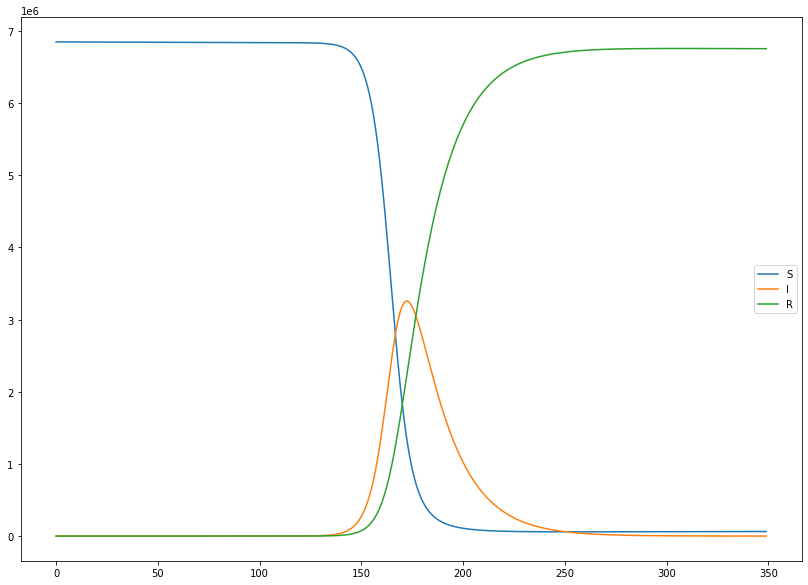

Iraq


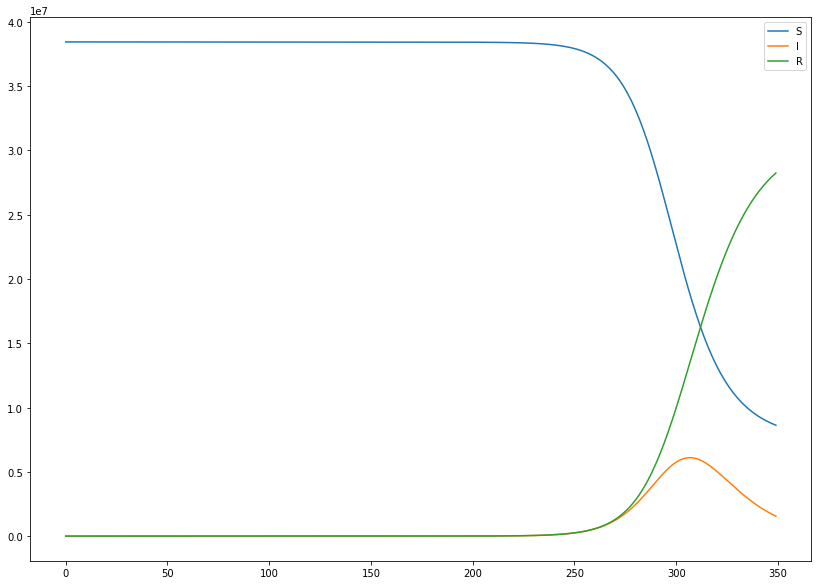

Egypt


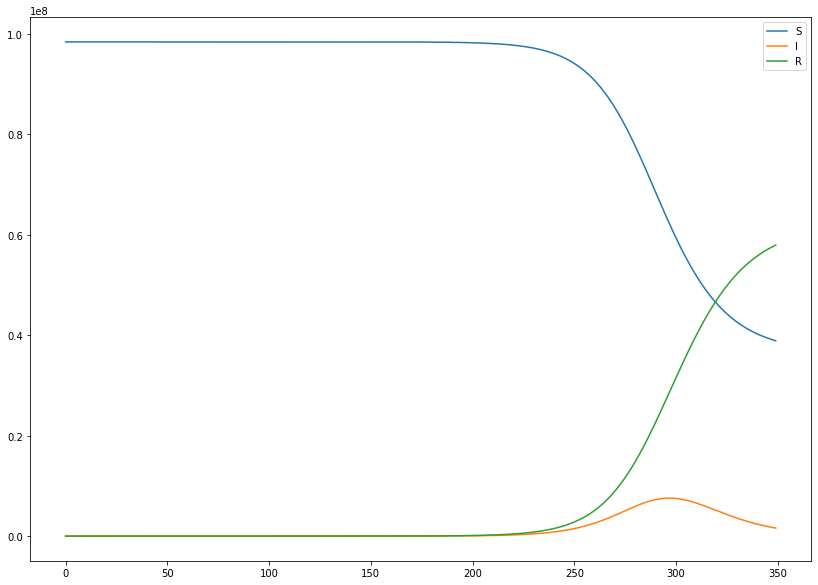

Cambodia


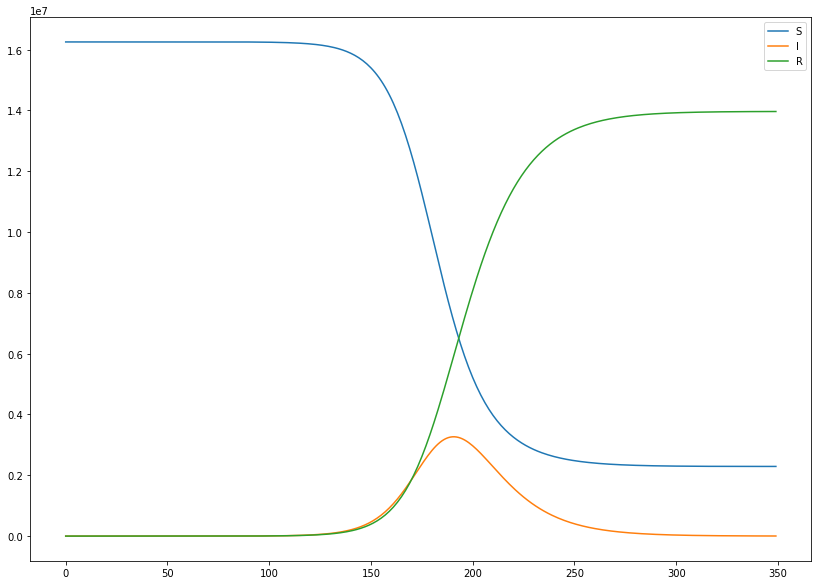

India


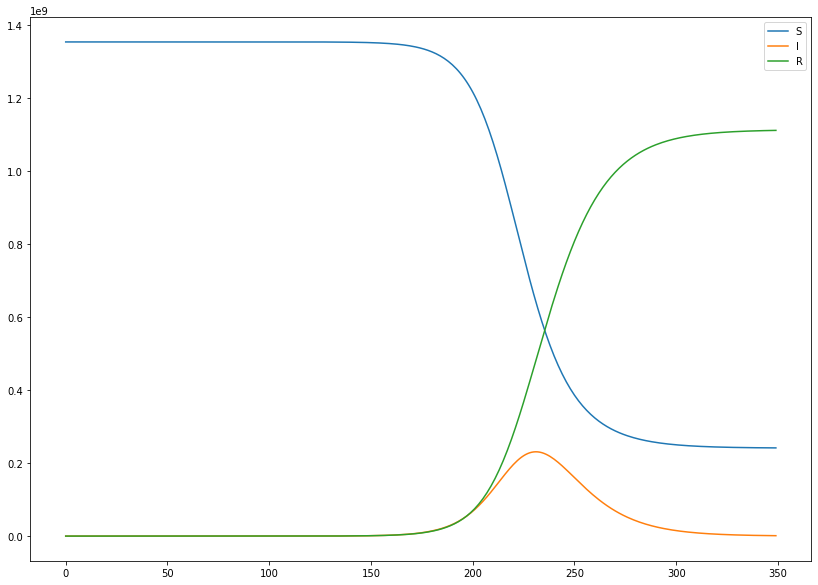

Nepal


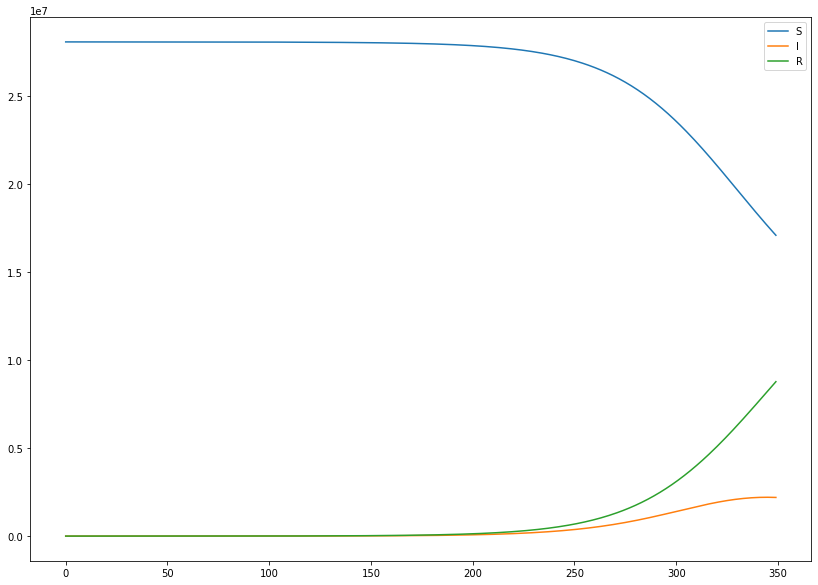

Afghanistan


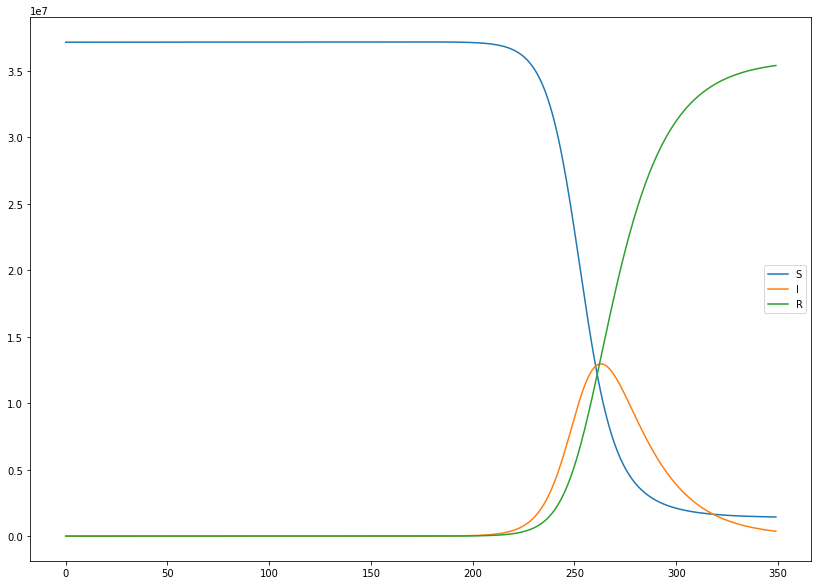

In [151]:
# Visualize simulation results
x = list(range(T))
for c in countries:
    print(c)
    plt.figure(figsize=(14,10))
    plt.plot(x, S_lists[c], label="S")
    plt.plot(x, I_lists[c], label="I")
    plt.plot(x, R_lists[c], label="R")
    plt.legend()
    plt.show()


World


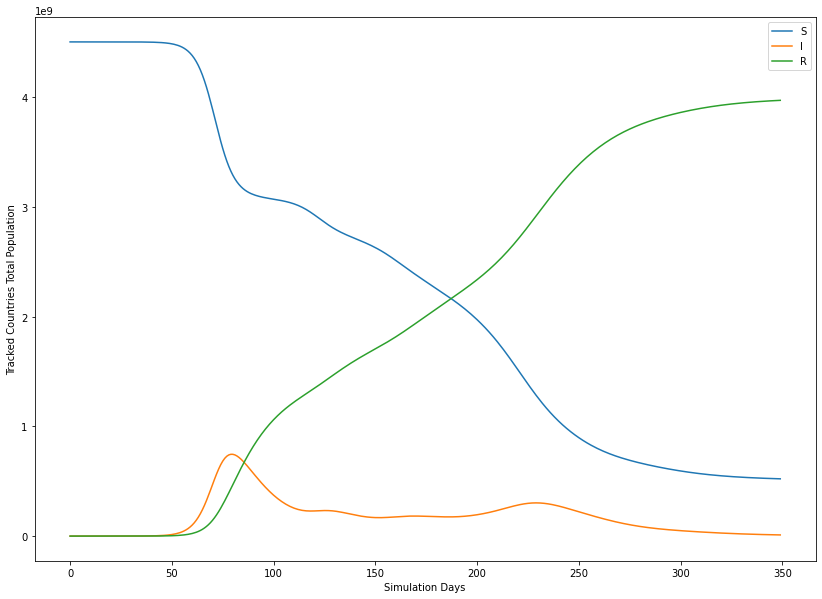

In [152]:
# World total
print("World")
plt.figure(figsize=(14,10))
plt.plot(x, [np.array([S_lists[c][d] for c in countries]).sum() for d in range(T)], label="S")
plt.plot(x, [np.array([I_lists[c][d] for c in countries]).sum() for d in range(T)], label="I")
plt.plot(x, [np.array([R_lists[c][d] for c in countries]).sum() for d in range(T)], label="R")
plt.legend()
plt.xlabel('Simulation Days')
plt.ylabel('Tracked Countries Total Population')
plt.savefig(open("world-simulation.png", "wb"))

In [105]:
# Country betas; higher beta should give peak earlier
{k: v for k, v in sorted(country_betas.items(), key=lambda item: -item[1])}

{'Spain': 0.3014995166850214,
 'South Korea': 0.29978333939800106,
 'Israel': 0.2895537742427694,
 'Lebanon': 0.28111070515162584,
 'China': 0.27633667502088555,
 'Iran': 0.2525572231386184,
 'United States': 0.23556176563019396,
 'Germany': 0.22550139695005025,
 'Belgium': 0.22176213482821683,
 'Italy': 0.21652416221262968,
 'United Kingdom': 0.21330205492357193,
 'Finland': 0.20800011239159588,
 'Oman': 0.1992703760885579,
 'Egypt': 0.19286937421552808,
 'Sweden': 0.1925838857757689,
 'Canada': 0.19184445776293044,
 'France': 0.19073039934871855,
 'Afghanistan': 0.19007771889127817,
 'Russia': 0.1877648172495816,
 'Philippines': 0.18707527887268754,
 'Iraq': 0.1859372104695664,
 'India': 0.17900912669292174,
 'Cambodia': 0.1637907061526249,
 'Australia': 0.15940278191783444,
 'Japan': 0.15451445573396794,
 'Malaysia': 0.14867619842623406,
 'Kuwait': 0.1394269337065947,
 'Bahrain': 0.13638380394435756,
 'Singapore': 0.13455109986661104,
 'United Arab Emirates': 0.1329977923735003,
 'T

In [16]:
# For each country which simulation day sees the pick 
countries_peak_day = {c: I_lists[c].index(max(I_lists[c])) for c in countries}
{k: v for k, v in sorted(countries_peak_day.items(), key=lambda item: item[1])}

{'China': 79,
 'South Korea': 87,
 'United States': 128,
 'Israel': 140,
 'Sweden': 153,
 'Macau': 159,
 'Japan': 165,
 'Canada': 169,
 'Iran': 169,
 'Spain': 169,
 'Lebanon': 171,
 'Russia': 175,
 'United Kingdom': 182,
 'Italy': 188,
 'Cambodia': 194,
 'Australia': 199,
 'Taiwan': 200,
 'Hong Kong': 204,
 'Germany': 208,
 'France': 220,
 'Malaysia': 220,
 'Finland': 223,
 'Belgium': 223,
 'Oman': 227,
 'India': 228,
 'United Arab Emirates': 232,
 'Sri Lanka': 243,
 'Singapore': 247,
 'Thailand': 250,
 'Philippines': 259,
 'Afghanistan': 261,
 'Kuwait': 283,
 'Egypt': 294,
 'Iraq': 296,
 'Bahrain': 299,
 'Vietnam': 300,
 'Nepal': 338}

In [155]:
# Calculate Percentage change in total population for each country
pct_values = []
for c in countries:
    final_population = S_lists[c][-1] + I_lists[c][-1] + R_lists[c][-1]
    pct_change = ((final_population - country_populations[c]) / country_populations[c])*100
    pct_values.append(pct_change)
    print(c, pct_change)
np.array(pct_values).mean()

South Korea -1.020943790543966
Israel -1.1024548950307136
Philippines -0.009645564934863626
United States 0.12042085909265857
United Kingdom -5.477626799985128
Singapore 5.464201831286298
Sweden 3.976048936126219
Italy 0.4487986854502308
France -2.767068879700298
Finland -4.538542979728334
Vietnam 0.0554772727001143
Russia -0.15725059633935573
Macau 43.43040817642566
Taiwan -2.259871640040518
Japan -0.4320123722751932
Malaysia -0.3055315340553706
Thailand -0.9668273045385894
Germany -1.7382177675302521
Australia -1.4830955882730754
United Arab Emirates -4.028173293323172
Canada 6.705396975811083
Bahrain 8.466166442022265
Iran 0.11745420604276896
Belgium -4.998072879868732
China 0.17229903304004165
Spain 9.590647318721688
Hong Kong -3.241988184189714
Sri Lanka -0.479856136574186
Kuwait -1.2737573042041292
Oman -0.7993771668449987
Lebanon -0.4432530686113879
Iraq -0.07520354267961231
Egypt 0.013478803387654854
Cambodia 0.03793964978168385
India 0.027987157108728948
Nepal -0.0615186964499

1.110617393260738

World


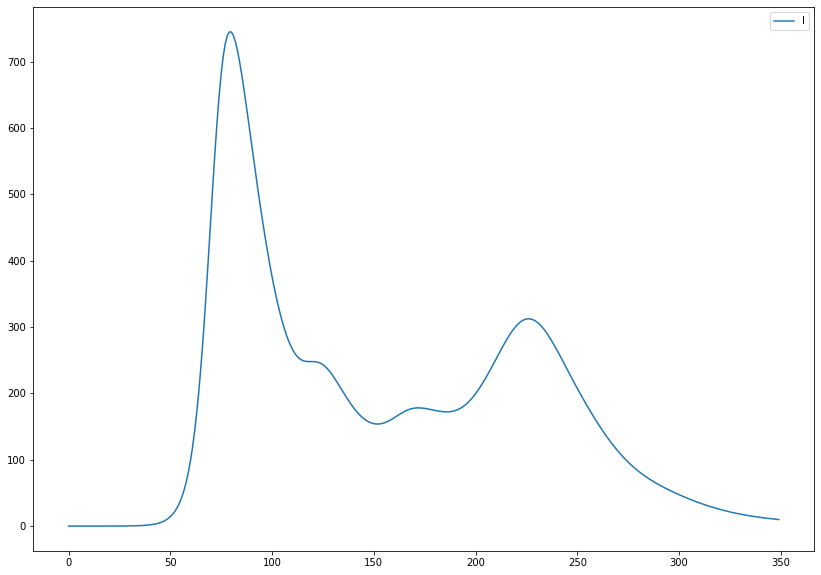

In [17]:
# World total Infected (1/1000000)
print("World")
plt.figure(figsize=(14,10))
plt.plot(x, [np.array([I_lists[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="I")
plt.legend()
plt.show()

## Simulation with travel restrictions
Significantly reduce international air traffic after a number of days that registered confirmed cases.

In [167]:
# Simulation with travel restrictions
S_lists_tr = {}
I_lists_tr = {}
R_lists_tr = {}

# Initialise lists values
for c in countries:
    S_lists_tr[c] = [ country_populations[c] ]
    I_lists_tr[c] = [ confirmed.loc[c, confirmed.columns[0]] ]
    R_lists_tr[c] = [ deaths.loc[c, deaths.columns[0]] ]
    
# Percentage of air traffic retained
air_traffic_perc = 0.1
# Days with confirmed cases after which apply travel restrictions
days_with_cases = 10

# Carry out simulation
for t in range(1, T):
    for c in countries:
        # Get people coming into the country for each compartment
        S_in_t = 0
        I_in_t = 0
        R_in_t = 0
        for n in g.nodes():
            if g.get_edge_data(n, c) is not None:
                if t >= days_with_cases and I_lists_tr[c][-days_with_cases] > 1:
                    n_in_route = g.get_edge_data(n, c)['weight'] * air_traffic_perc
                else: 
                    n_in_route = g.get_edge_data(n, c)['weight']
                n_total_pop = S_lists_tr[n][t-1] + I_lists_tr[n][t-1] + R_lists_tr[n][t-1]
                n_in_population = n_in_route * np.log10(n_total_pop)
                S_in_t += (S_lists_tr[n][t-1] / n_total_pop) * n_in_population
                I_in_t += (I_lists_tr[n][t-1] / n_total_pop) * n_in_population
                R_in_t += (R_lists_tr[n][t-1] / n_total_pop) * n_in_population
        # Get people going out of the country for each compartment
        current_population = S_lists_tr[c][t-1] + I_lists_tr[c][t-1] + R_lists_tr[c][t-1]
        if t >= days_with_cases and I_lists_tr[c][-days_with_cases] > 1:
            out_population = air_traffic_perc * out_routes[c] * np.log10(current_population)
        else:
            out_population = out_routes[c] * np.log10(current_population)
        S_out_t = (S_lists_tr[c][t-1] / current_population) * out_population
        I_out_t = (I_lists_tr[c][t-1] / current_population) * out_population
        R_out_t = (R_lists_tr[c][t-1] / current_population) * out_population

        S_t = S_lists_tr[c][t-1] - ((S_lists_tr[c][t-1] / S_lists_tr[c][0]) * (country_betas[c]*I_lists_tr[c][t-1]))
        S_lists_tr[c].append(S_t - S_out_t + S_in_t)
        
        I_t = I_lists_tr[c][t-1] + ((S_lists_tr[c][t-1] / S_lists_tr[c][0]) * (country_betas[c]*I_lists_tr[c][t-1])) - (I_lists_tr[c][t-1] * country_gammas[c])
        I_lists_tr[c].append(I_t - I_out_t + I_in_t)
        
        R_t = R_lists_tr[c][t-1] + (I_lists_tr[c][t-1] * country_gammas[c])
        R_lists_tr[c].append(R_t - R_out_t + R_in_t)
        
      

World


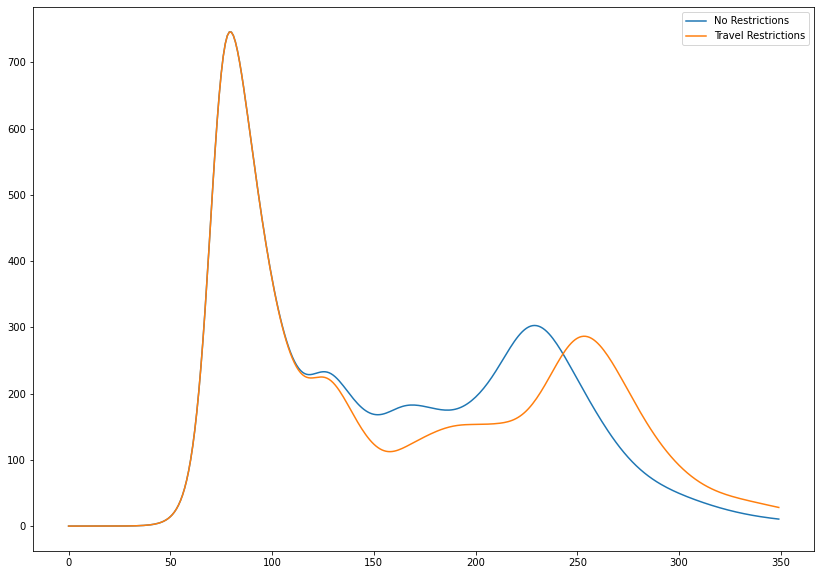

In [168]:
# World total Infected (1/1000000)
print("World")
plt.figure(figsize=(14,10))
plt.plot(x, [np.array([I_lists[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="No Restrictions")
plt.plot(x, [np.array([I_lists_tr[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="Travel Restrictions")
plt.legend()
plt.show()

South Korea


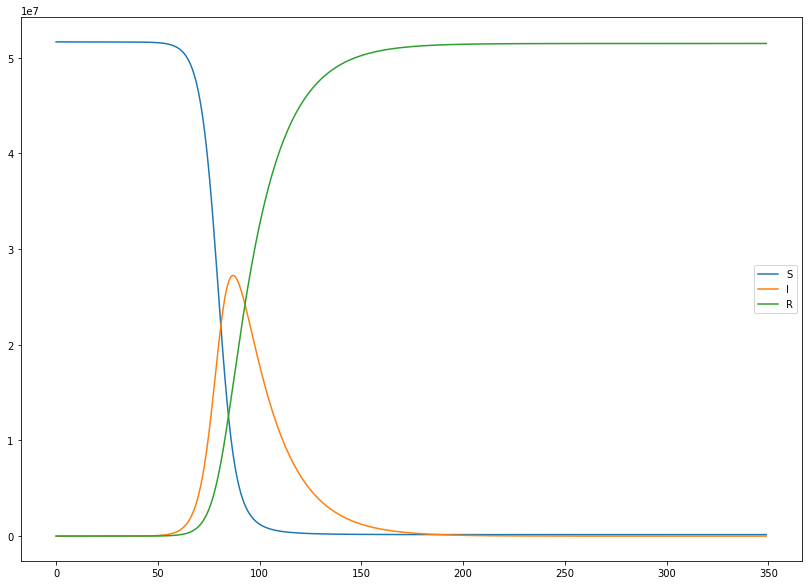

Israel


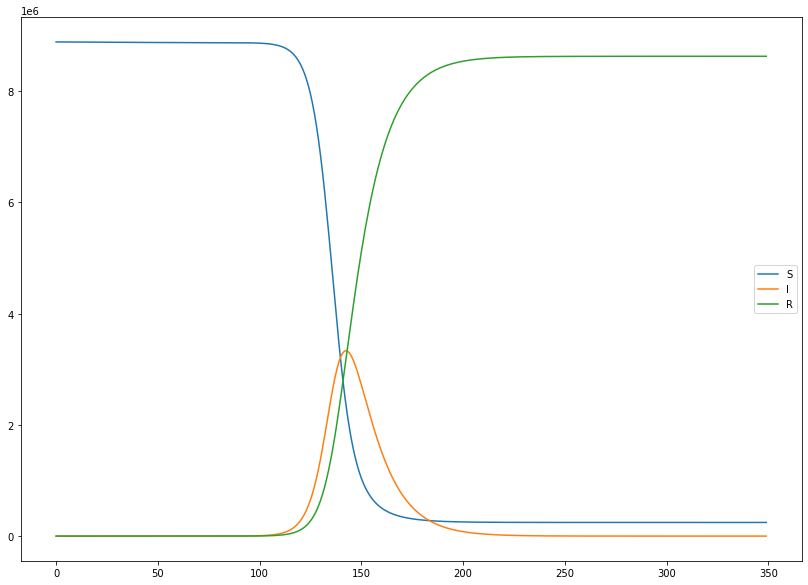

Philippines


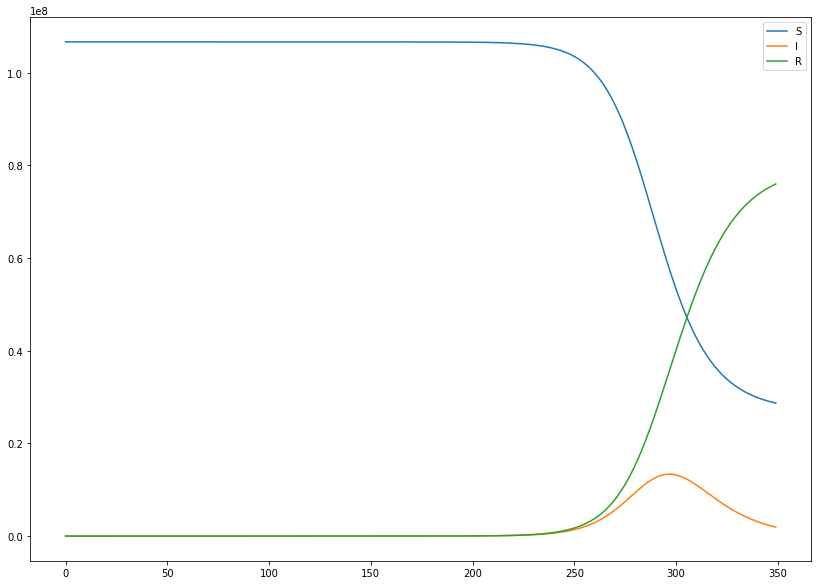

United States


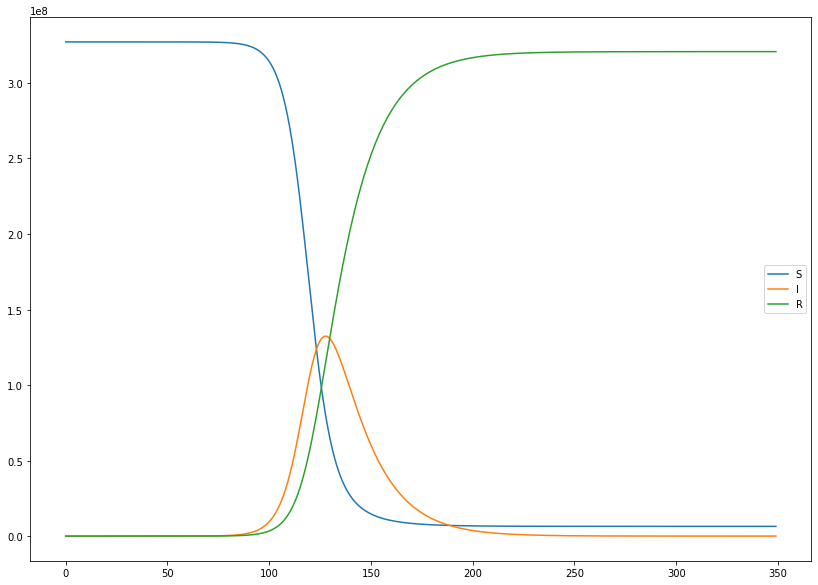

United Kingdom


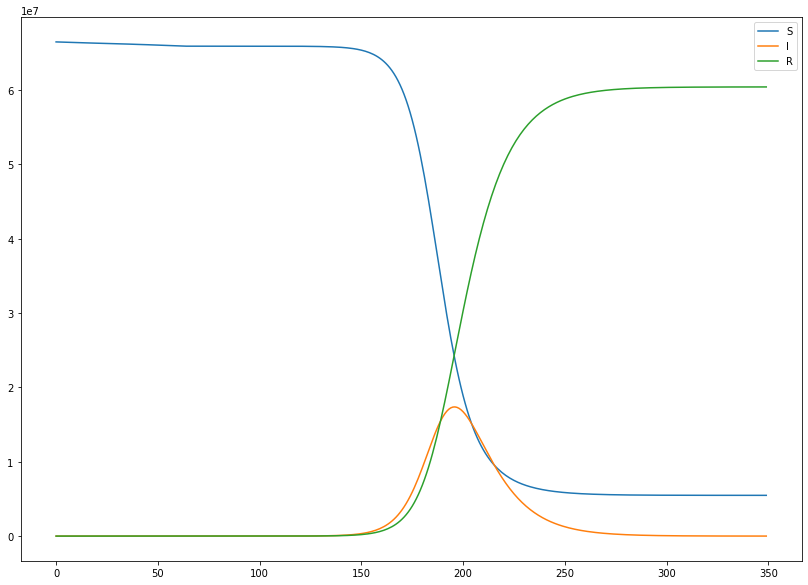

Singapore


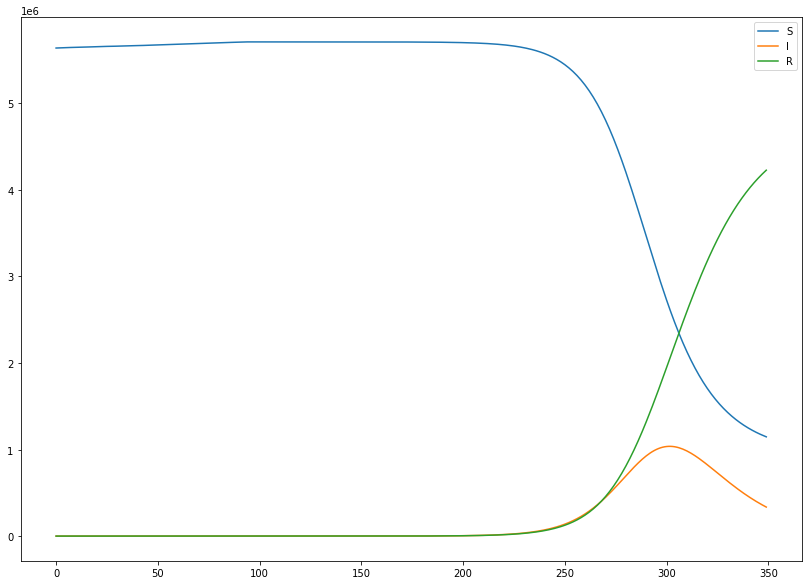

Sweden


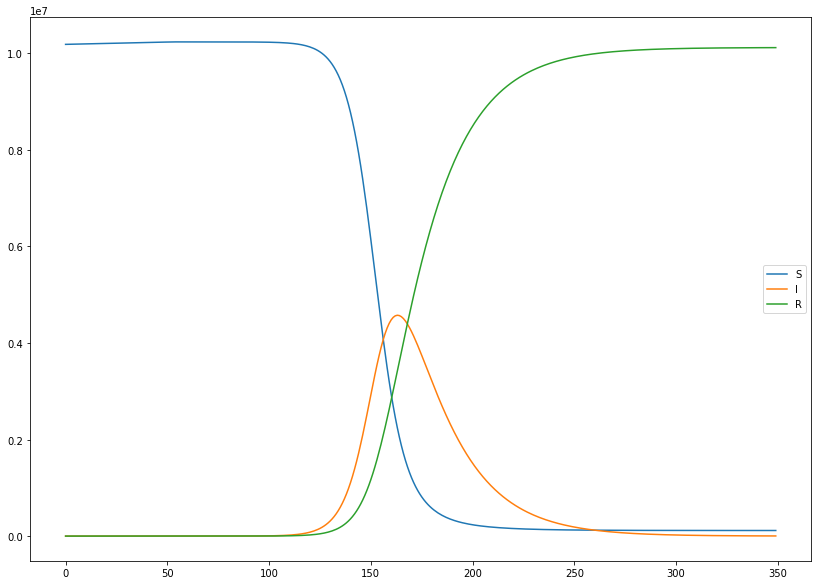

Italy


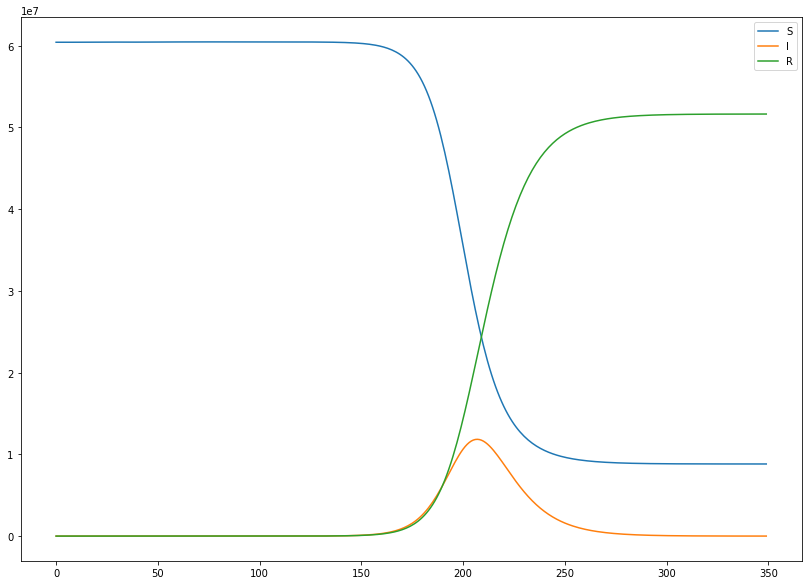

France


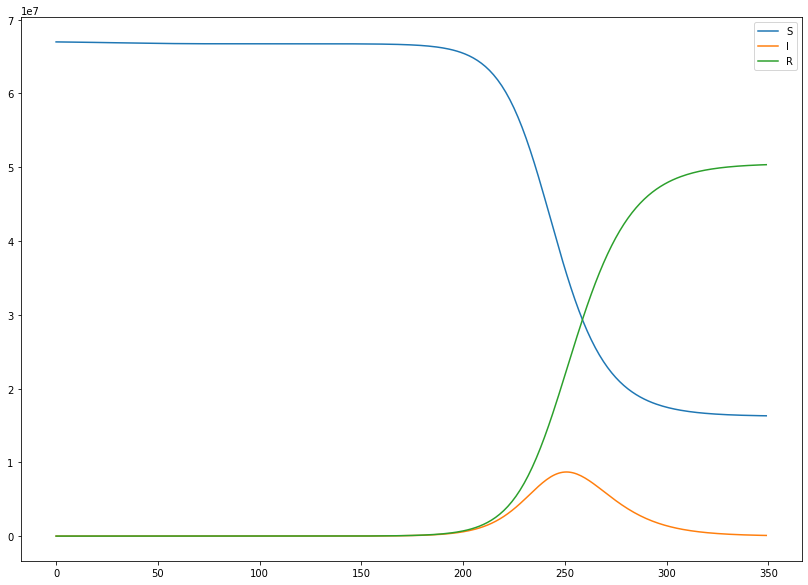

Finland


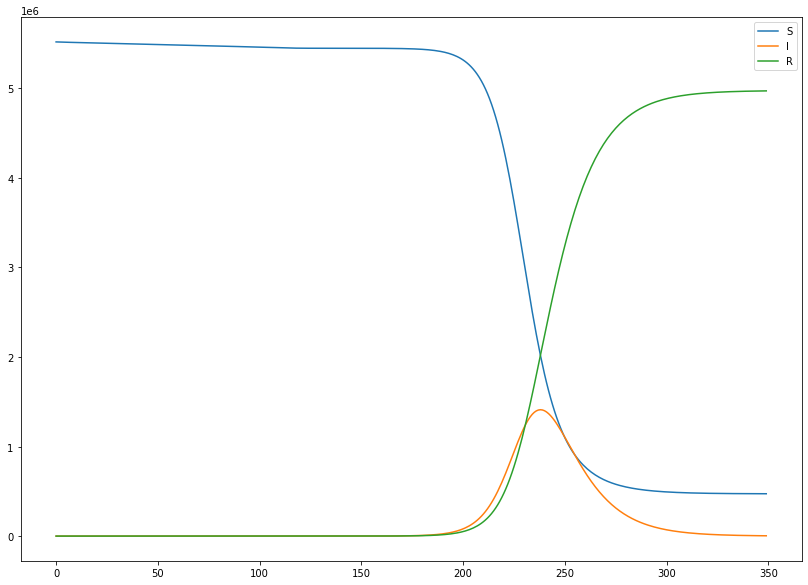

Vietnam


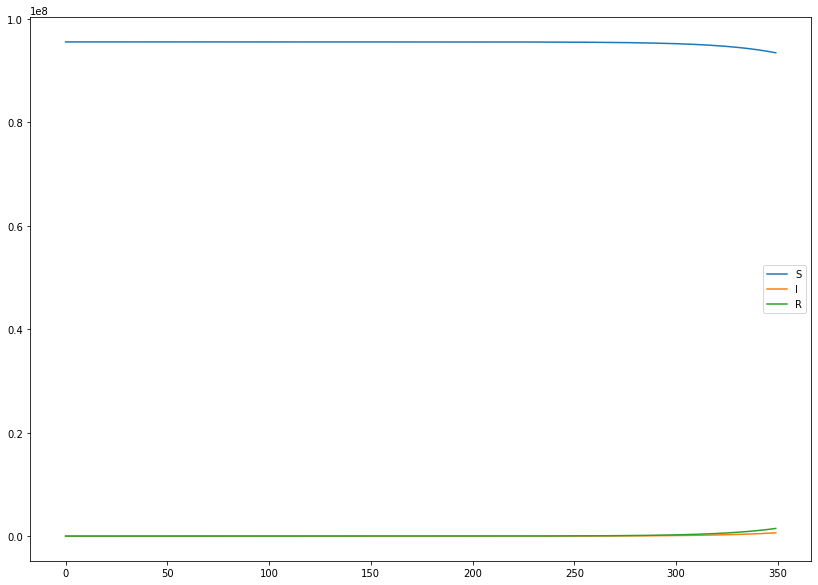

Russia


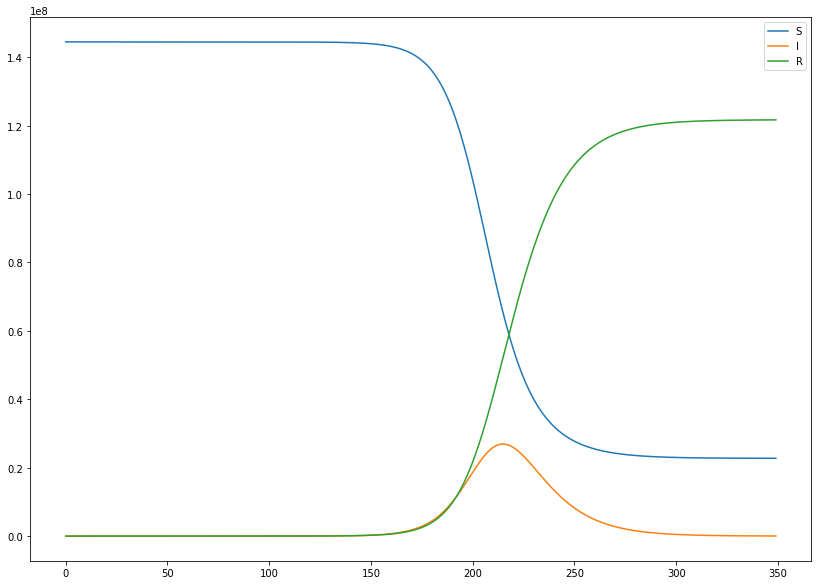

Macau


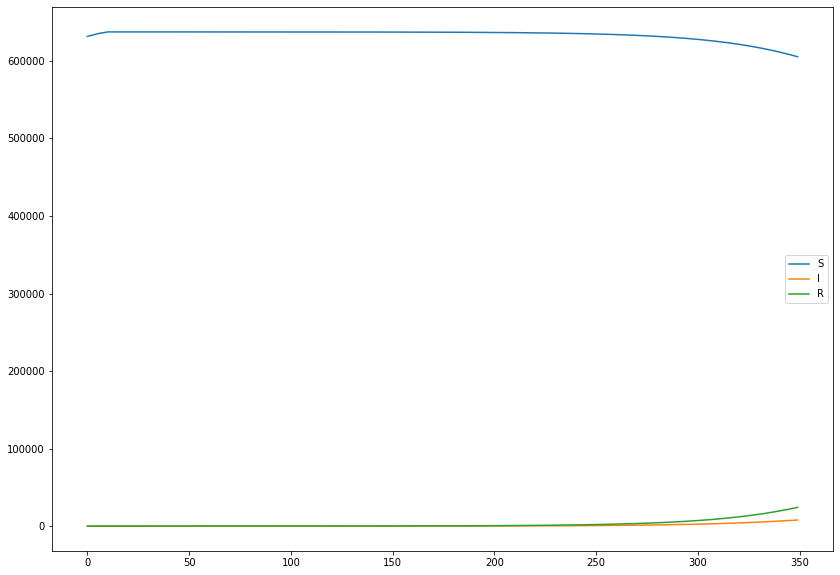

Taiwan


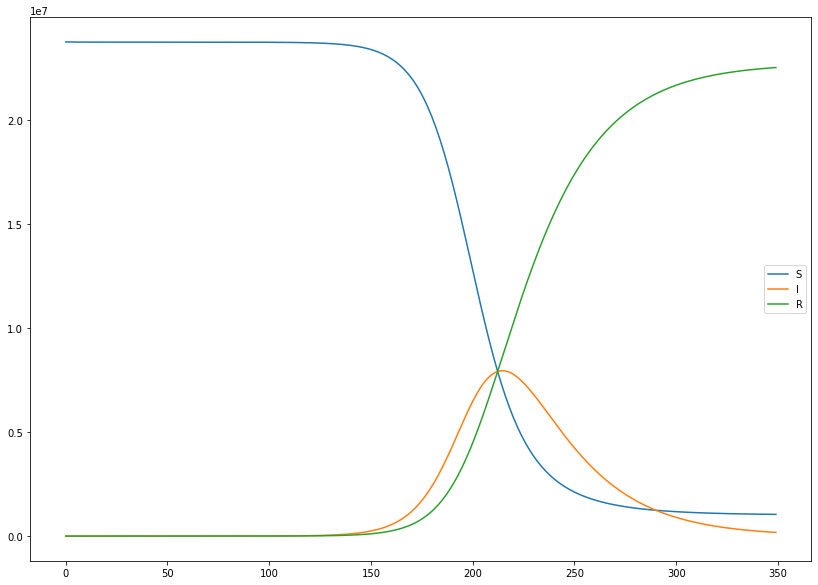

Japan


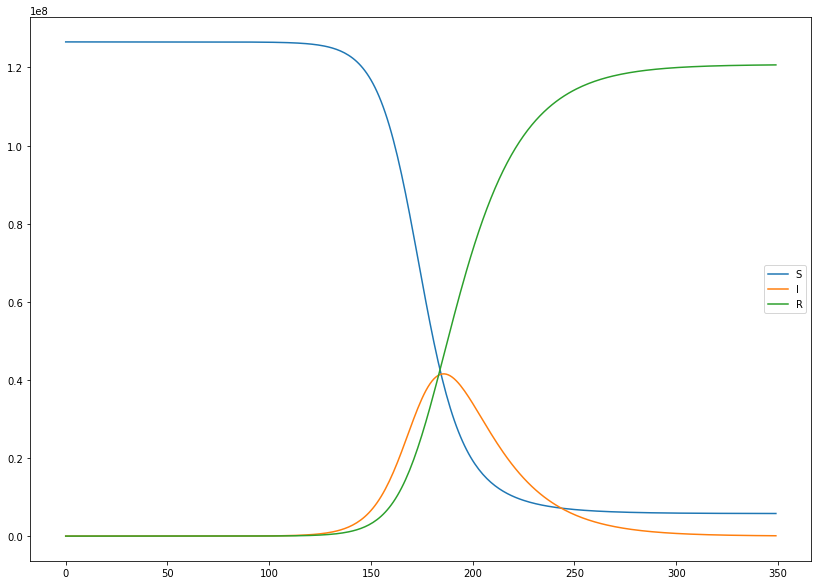

Malaysia


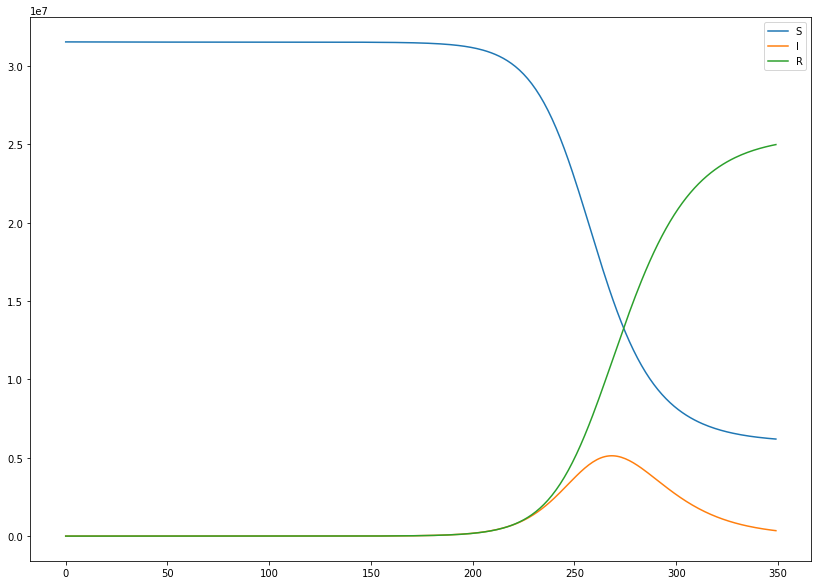

Thailand


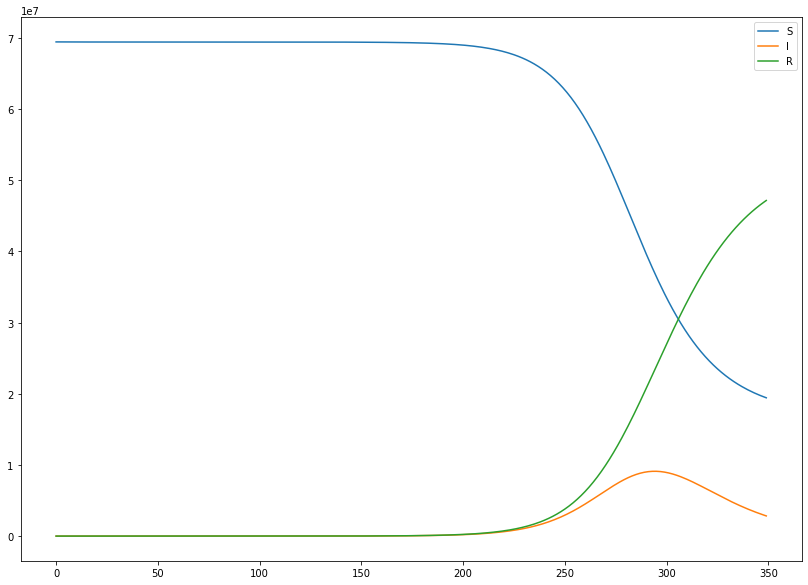

Germany


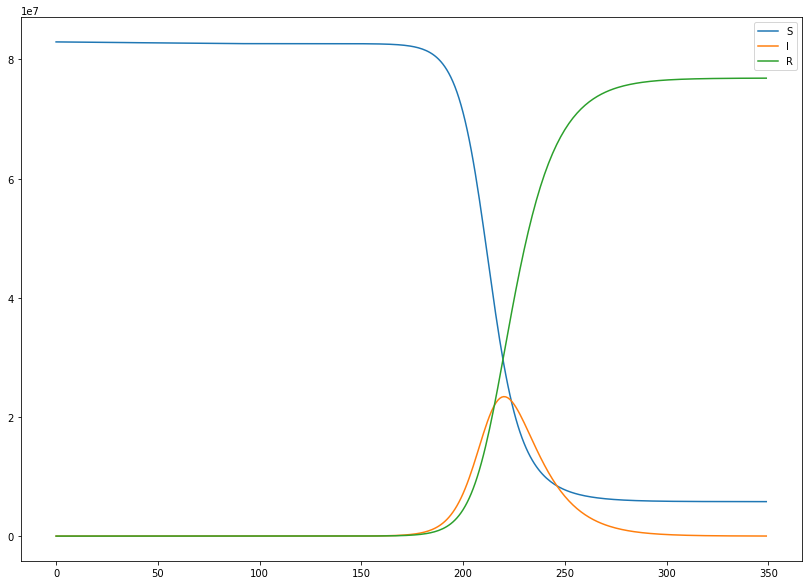

Australia


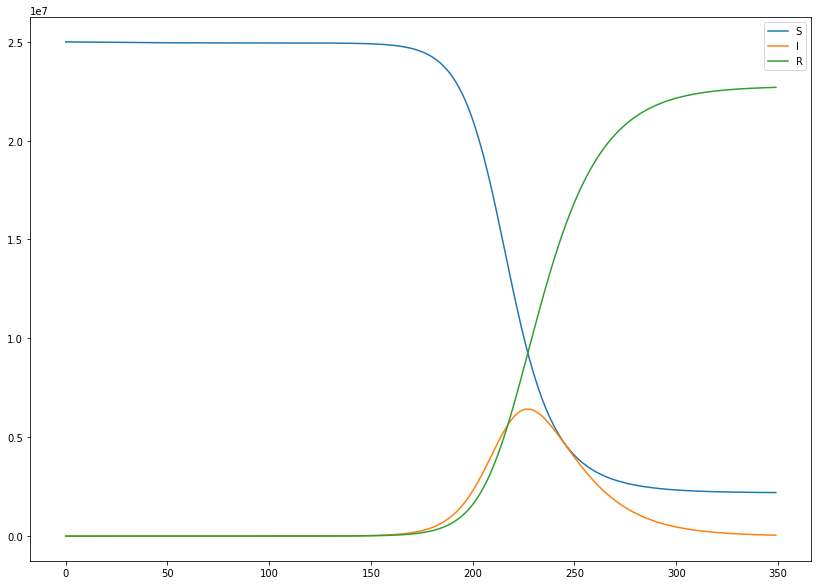

United Arab Emirates


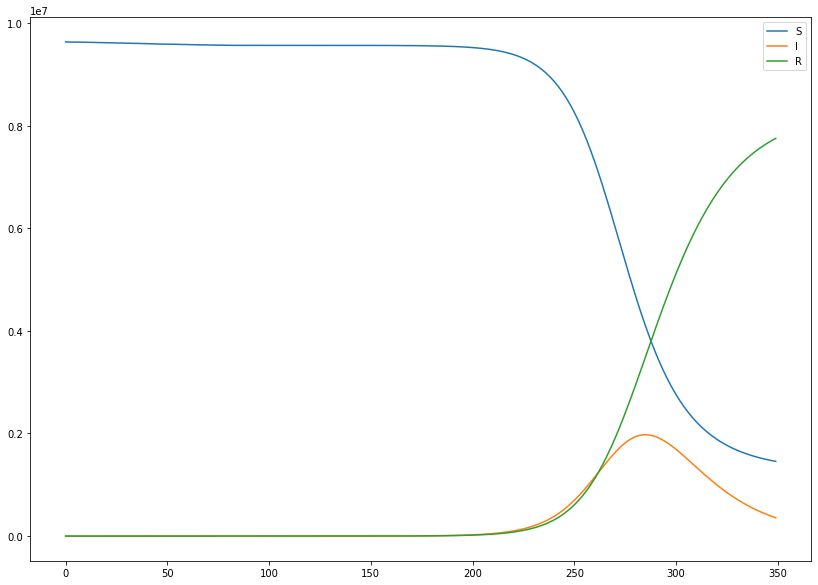

Canada


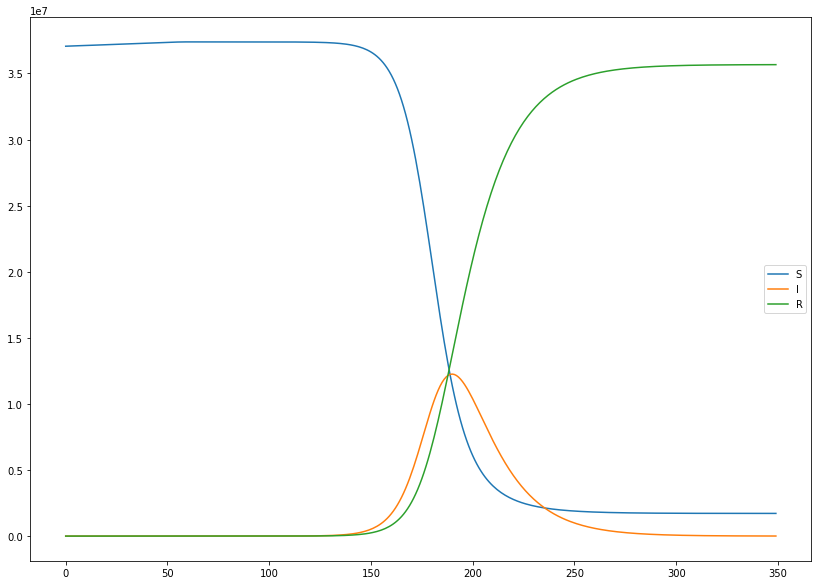

Bahrain


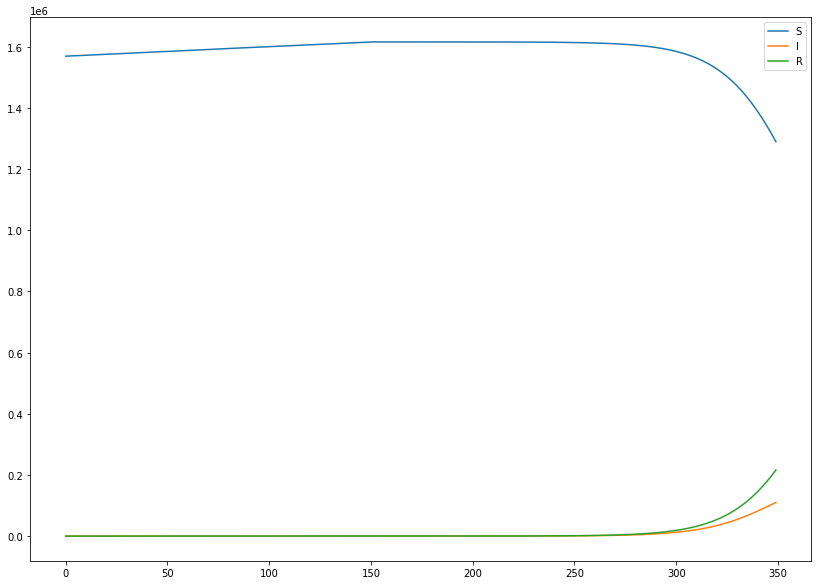

Iran


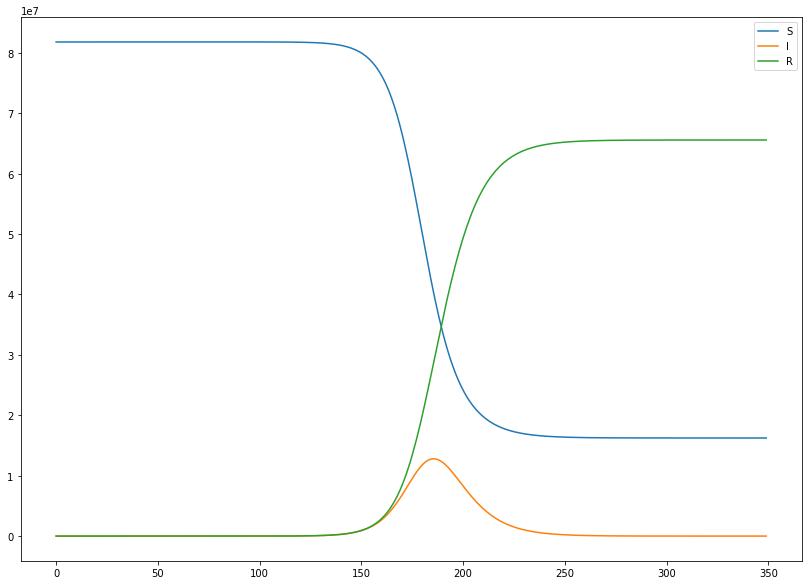

Belgium


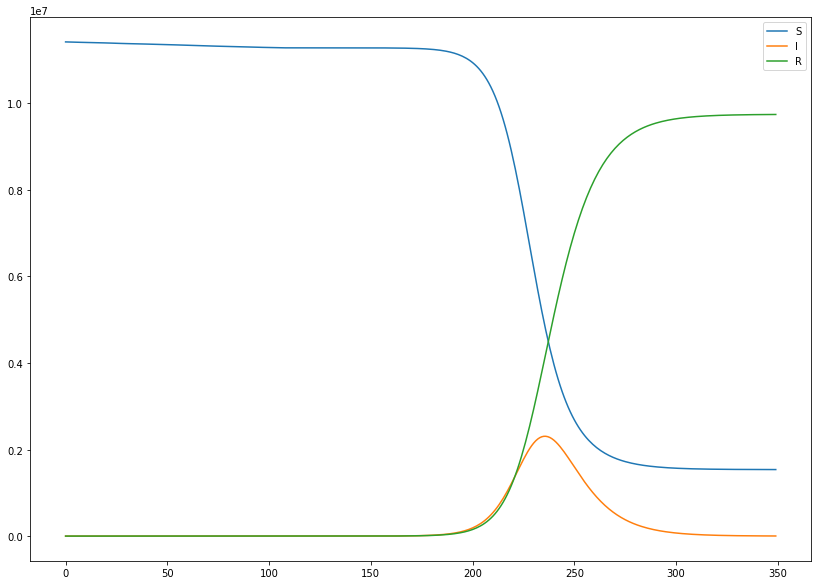

China


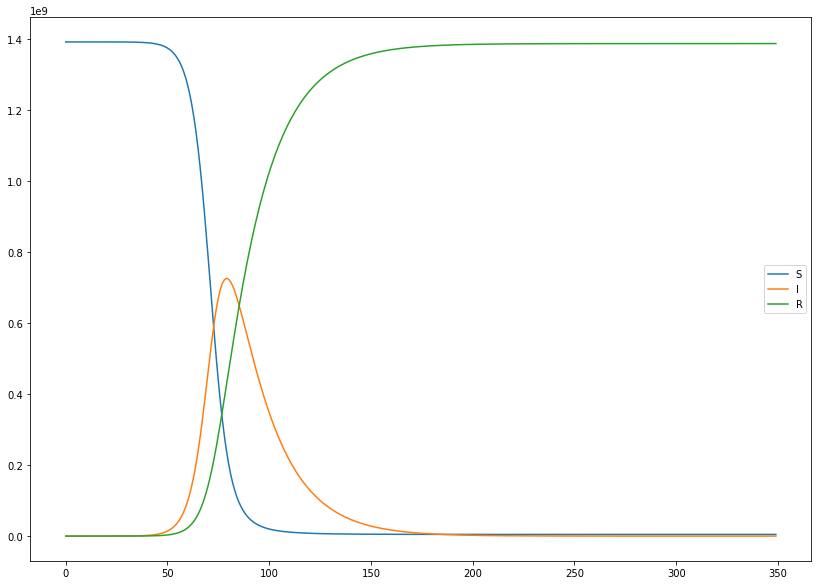

Spain


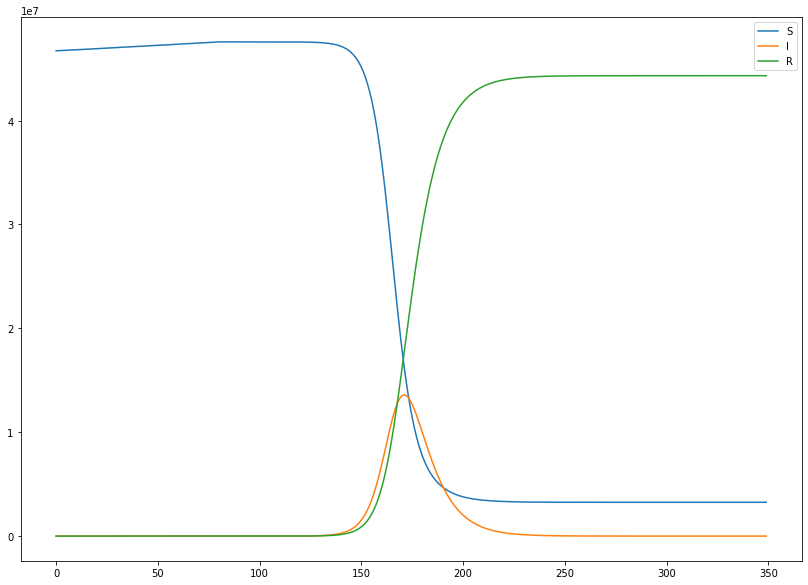

Hong Kong


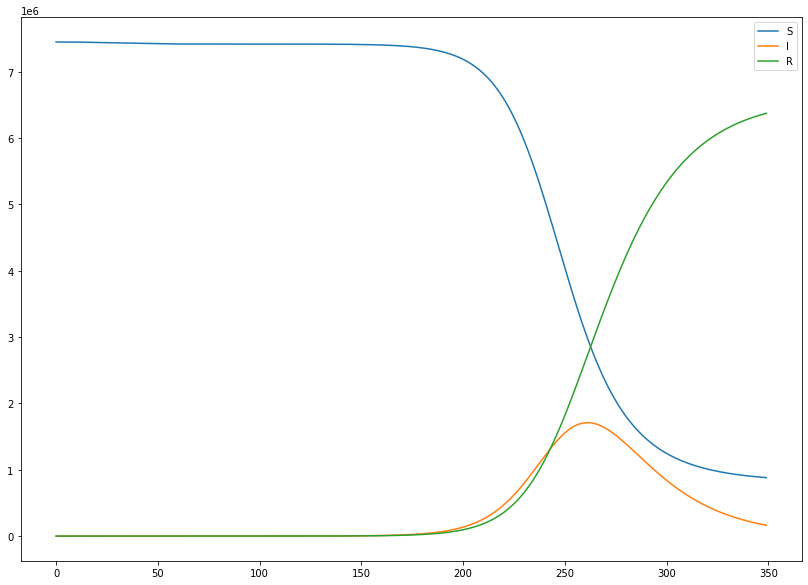

Sri Lanka


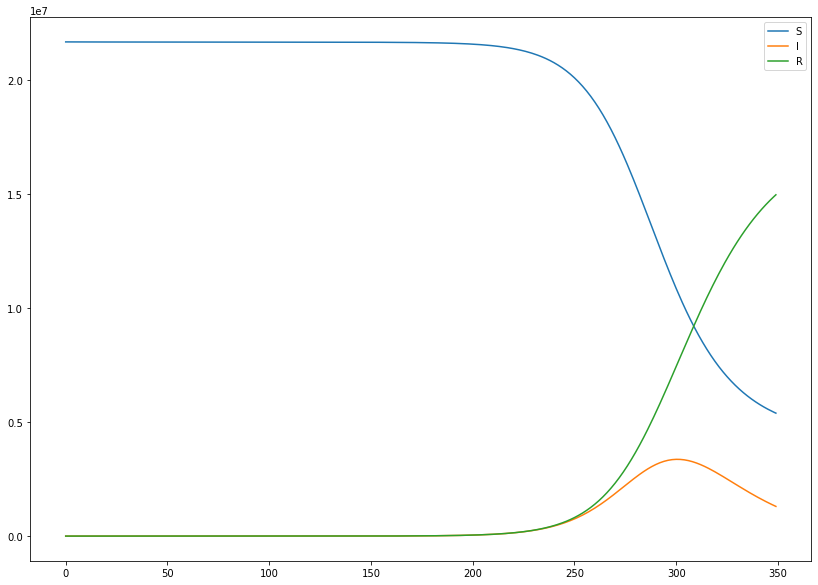

Kuwait


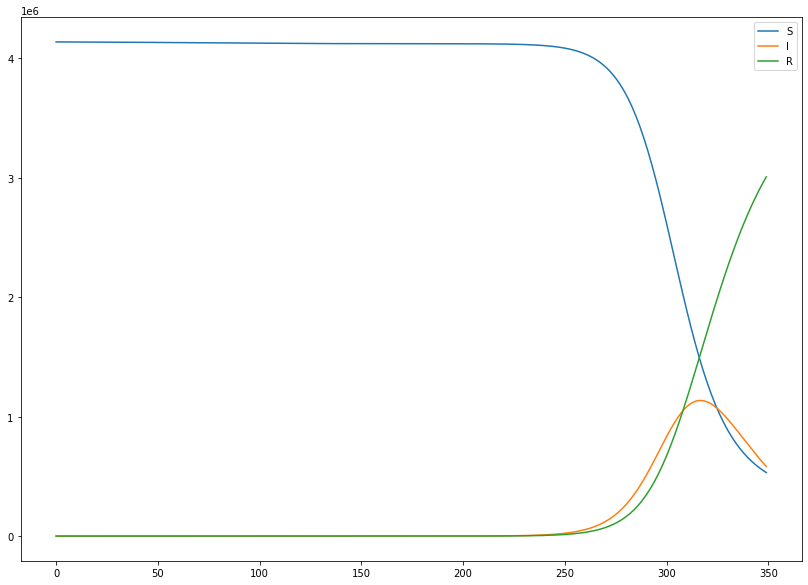

Oman


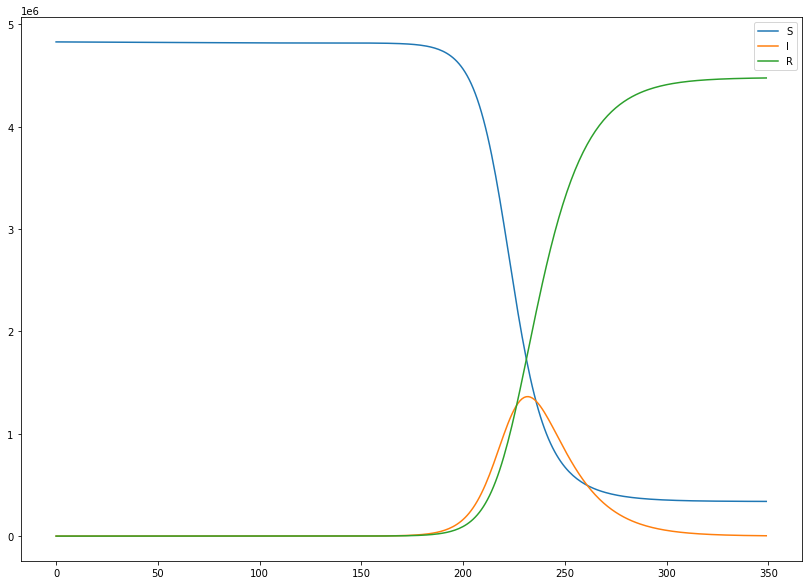

Lebanon


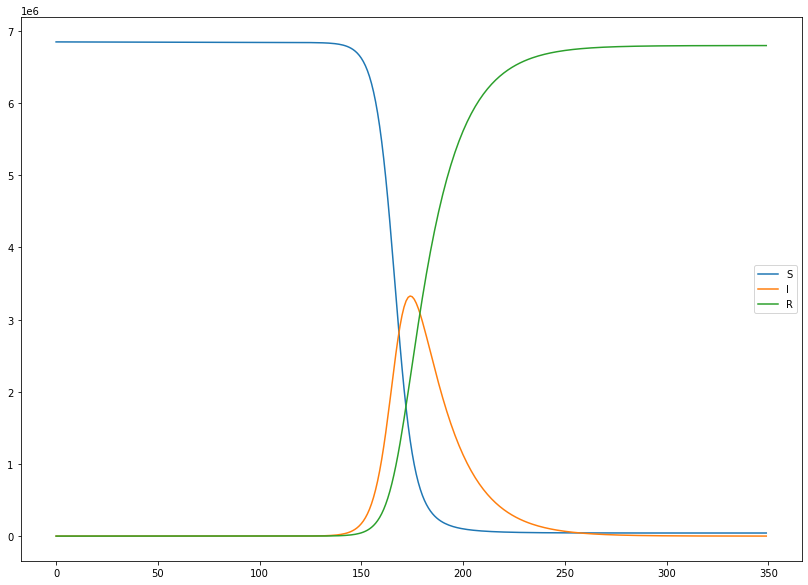

Iraq


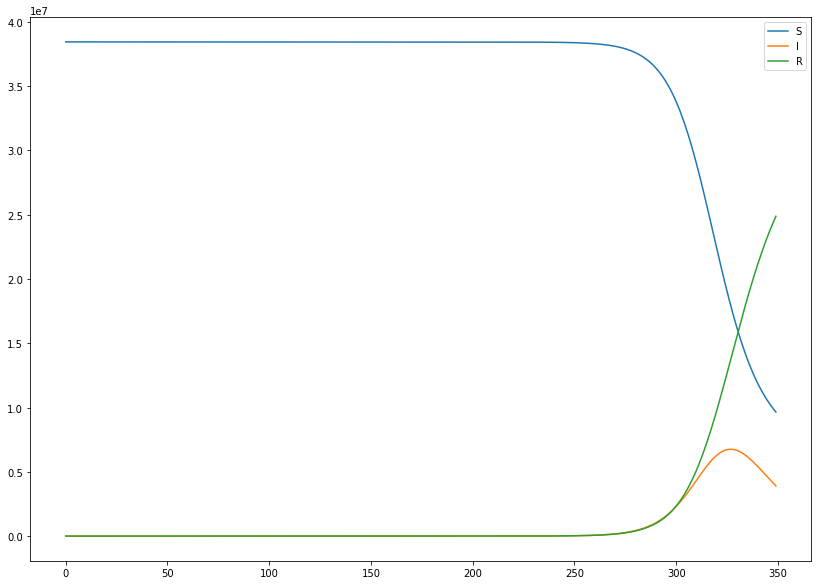

Egypt


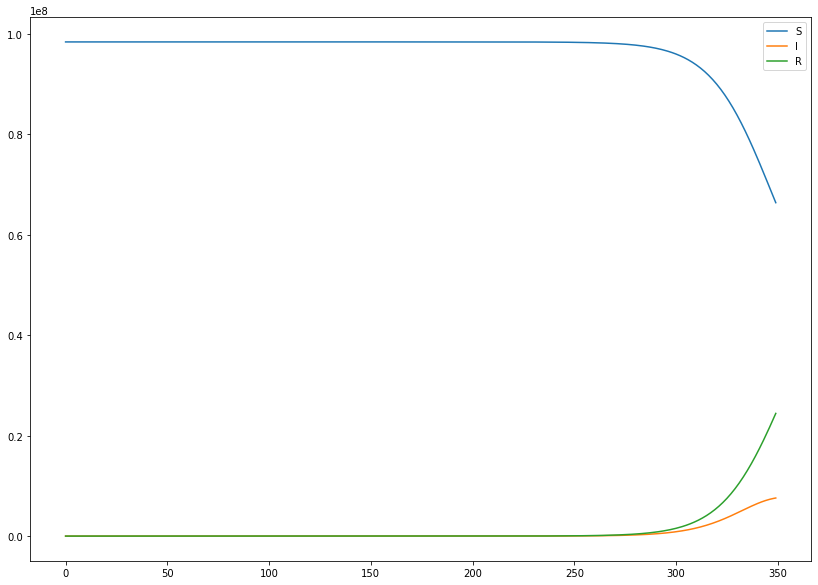

Cambodia


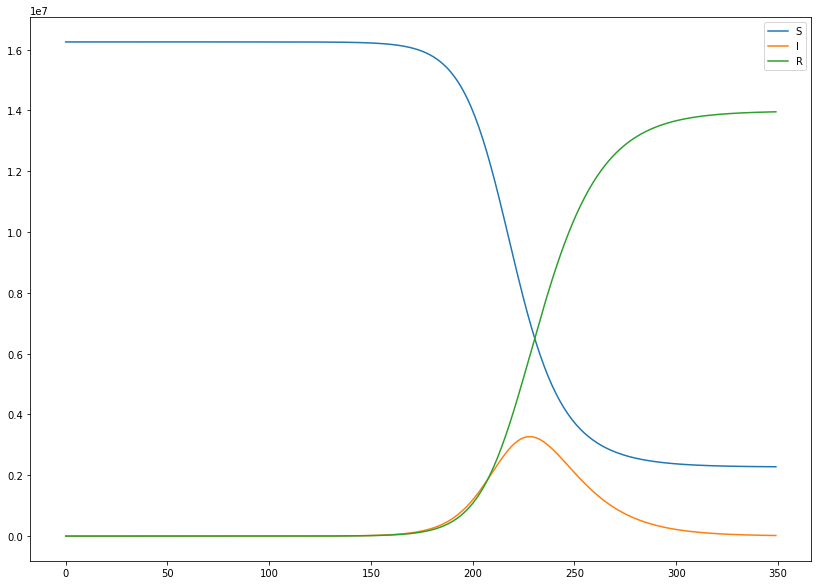

India


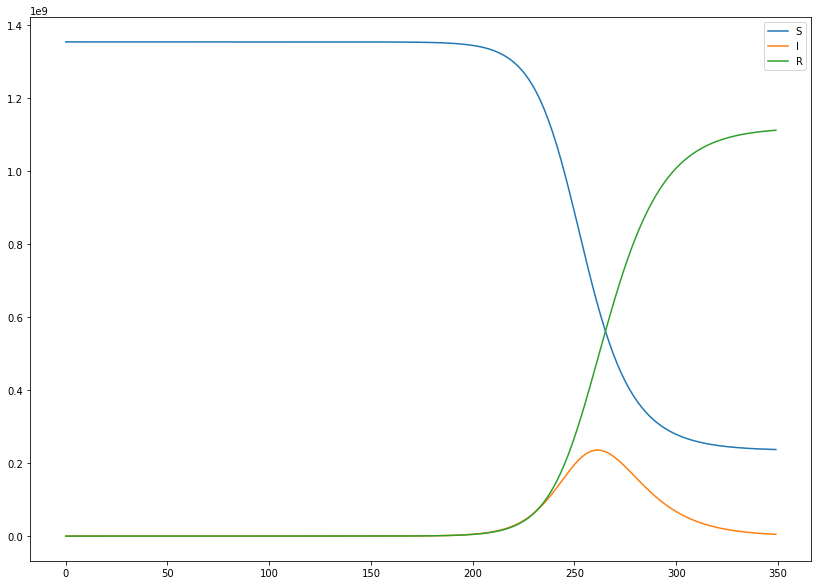

Nepal


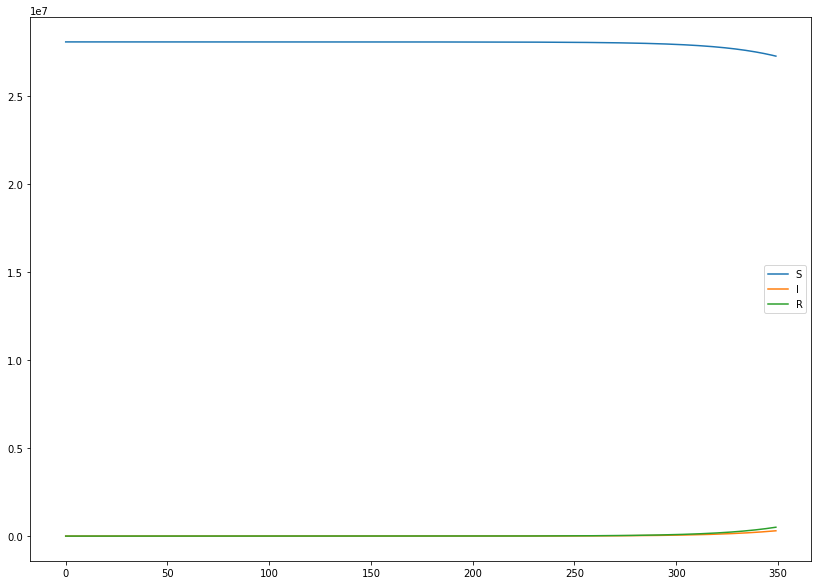

Afghanistan


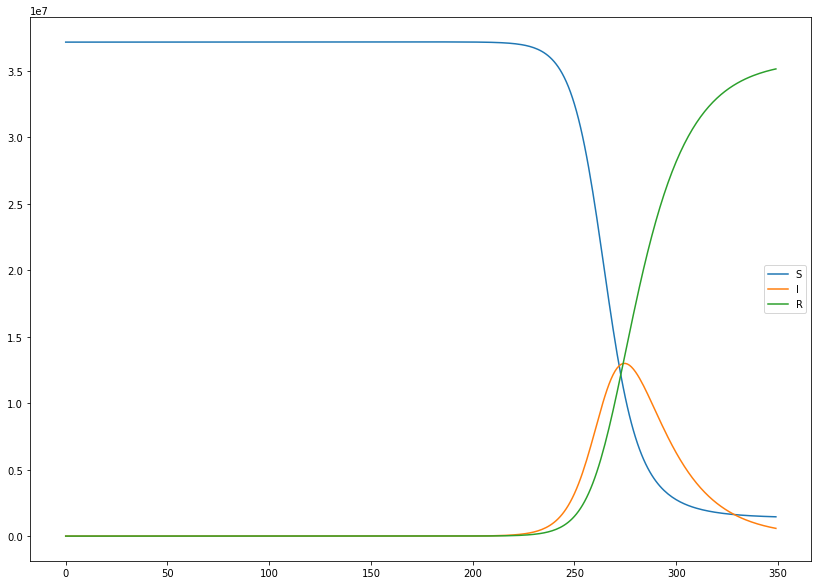

In [20]:
# Visualize simulation results
x = list(range(T))
for c in countries:
    print(c)
    plt.figure(figsize=(14,10))
    plt.plot(x, S_lists_tr[c], label="S")
    plt.plot(x, I_lists_tr[c], label="I")
    plt.plot(x, R_lists_tr[c], label="R")
    plt.legend()
    plt.show()

In [21]:
# Show how travel restrictions delayed the peak for each country
countries_peak_day_tr = {c: I_lists_tr[c].index(max(I_lists_tr[c])) for c in countries}
countries_peak_delay_tr = {k: countries_peak_day_tr[k]-v for k, v in countries_peak_day.items()}

{k: v for k, v in sorted(countries_peak_delay_tr.items(), key=lambda item: item[1])}

{'South Korea': 0,
 'United States': 0,
 'China': 0,
 'Israel': 2,
 'Spain': 2,
 'Lebanon': 3,
 'Oman': 5,
 'Sweden': 10,
 'Nepal': 11,
 'Germany': 12,
 'Belgium': 13,
 'United Kingdom': 14,
 'Afghanistan': 14,
 'Finland': 15,
 'Taiwan': 15,
 'Iran': 17,
 'Italy': 19,
 'Japan': 21,
 'Canada': 21,
 'Australia': 28,
 'France': 31,
 'Iraq': 31,
 'India': 33,
 'Kuwait': 34,
 'Cambodia': 34,
 'Philippines': 38,
 'Russia': 40,
 'Thailand': 44,
 'Malaysia': 48,
 'Vietnam': 49,
 'Bahrain': 50,
 'United Arab Emirates': 53,
 'Singapore': 55,
 'Egypt': 55,
 'Hong Kong': 57,
 'Sri Lanka': 58,
 'Macau': 190}

## Simulation with lockdown
Isolation of individuals is applied by reducing the percentage of the population in the Susceptible compartment after a number of days with confirmed cases.

In [171]:
# Simulation with travel restrictions
S_lists_lock = {}
I_lists_lock = {}
R_lists_lock = {}

# Initialise lists values
for c in countries:
    S_lists_lock[c] = [ country_populations[c] ]
    I_lists_lock[c] = [ confirmed.loc[c, confirmed.columns[0]] ]
    R_lists_lock[c] = [ deaths.loc[c, deaths.columns[0]] ]
    
# Percentage of people still normally circulating
isolation_perc = 0.6
# Days with confirmed cases after which apply lockdown
days_with_cases = 10

# Carry out simulation
for t in range(1, T):
    for c in countries:
        # Get people coming into the country for each compartment
        S_in_t = 0
        I_in_t = 0
        R_in_t = 0
        for n in g.nodes():
            if g.get_edge_data(n, c) is not None:
                n_in_route = g.get_edge_data(n, c)['weight']
                n_total_pop = S_lists_lock[n][t-1] + I_lists_lock[n][t-1] + R_lists_lock[n][t-1]
                n_in_population = n_in_route * np.log10(n_total_pop)
                S_in_t += (S_lists_lock[n][t-1] / n_total_pop) * n_in_population
                I_in_t += (I_lists_lock[n][t-1] / n_total_pop) * n_in_population
                R_in_t += (R_lists_lock[n][t-1] / n_total_pop) * n_in_population
        # Get people going out of the country for each compartment
        current_population = S_lists_lock[c][t-1] + I_lists_lock[c][t-1] + R_lists_lock[c][t-1]
        out_population = out_routes[c] * np.log10(current_population)
        S_out_t = (S_lists_lock[c][t-1] / current_population) * out_population
        I_out_t = (I_lists_lock[c][t-1] / current_population) * out_population
        R_out_t = (R_lists_lock[c][t-1] / current_population) * out_population
    
        current_S = S_lists_lock[c][t-1]
        if t >= days_with_cases and I_lists_lock[c][-days_with_cases] > 1:
            current_S *= isolation_perc
        S_t = S_lists_lock[c][t-1] - ((current_S / S_lists_lock[c][0]) * (country_betas[c]*I_lists_lock[c][t-1])) 
        S_lists_lock[c].append(S_t - S_out_t + S_in_t)
        
        I_t = I_lists_lock[c][t-1] + ((current_S / S_lists_lock[c][0]) * (country_betas[c]*I_lists_lock[c][t-1])) - (I_lists_lock[c][t-1] * country_gammas[c])
        I_lists_lock[c].append(I_t - I_out_t + I_in_t)
        
        R_t = R_lists_lock[c][t-1] + (I_lists_lock[c][t-1] * country_gammas[c])
        R_lists_lock[c].append(R_t - R_out_t + R_in_t)
        
      

World


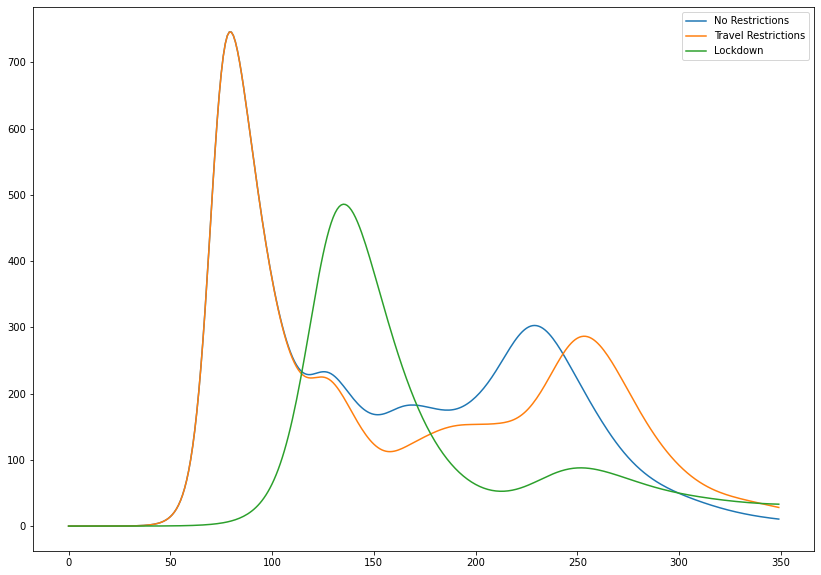

In [172]:
# World total Infected (1/1000000)
print("World")
plt.figure(figsize=(14,10))
plt.plot(x, [np.array([I_lists[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="No Restrictions")
plt.plot(x, [np.array([I_lists_tr[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="Travel Restrictions")
plt.plot(x, [np.array([I_lists_lock[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="Lockdown")
plt.legend()
plt.show()

In [55]:
# Show how isolation restrictions delayed the peak for each country
countries_peak_day_lock = {c: I_lists_lock[c].index(max(I_lists_lock[c])) for c in countries}
countries_peak_delay_lock = {k: countries_peak_day_lock[k]-v for k, v in countries_peak_day.items()}

{k: v for k, v in sorted(countries_peak_delay_lock.items(), key=lambda item: item[1])}

{'Vietnam': -129,
 'Nepal': -129,
 'Macau': 13,
 'Bahrain': 50,
 'Iraq': 53,
 'Egypt': 55,
 'China': 56,
 'South Korea': 61,
 'Kuwait': 66,
 'Lebanon': 69,
 'Afghanistan': 88,
 'Philippines': 90,
 'Israel': 93,
 'Thailand': 99,
 'Singapore': 102,
 'Sri Lanka': 106,
 'Sweden': 112,
 'United States': 115,
 'United Arab Emirates': 117,
 'Spain': 117,
 'India': 121,
 'Oman': 122,
 'Finland': 126,
 'Belgium': 126,
 'France': 129,
 'Malaysia': 129,
 'Germany': 141,
 'Hong Kong': 145,
 'Japan': 147,
 'Canada': 148,
 'Taiwan': 149,
 'Australia': 150,
 'Cambodia': 155,
 'Italy': 161,
 'United Kingdom': 167,
 'Russia': 174,
 'Iran': 180}

In [56]:
countries_peak_day_lock

{'South Korea': 148,
 'Israel': 233,
 'Philippines': 349,
 'United States': 243,
 'United Kingdom': 349,
 'Singapore': 349,
 'Sweden': 265,
 'Italy': 349,
 'France': 349,
 'Finland': 349,
 'Vietnam': 171,
 'Russia': 349,
 'Macau': 172,
 'Taiwan': 349,
 'Japan': 312,
 'Malaysia': 349,
 'Thailand': 349,
 'Germany': 349,
 'Australia': 349,
 'United Arab Emirates': 349,
 'Canada': 317,
 'Bahrain': 349,
 'Iran': 349,
 'Belgium': 349,
 'China': 135,
 'Spain': 286,
 'Hong Kong': 349,
 'Sri Lanka': 349,
 'Kuwait': 349,
 'Oman': 349,
 'Lebanon': 240,
 'Iraq': 349,
 'Egypt': 349,
 'Cambodia': 349,
 'India': 349,
 'Nepal': 209,
 'Afghanistan': 349}

## Simulation with Isolation of infected
Isolation of infected individuals is modelled by removing a percentage of the Infected compartment.

In [173]:
# Simulation with travel restrictions
S_lists_iso = {}
I_lists_iso = {}
R_lists_iso = {}

# Initialise lists values
for c in countries:
    S_lists_iso[c] = [ country_populations[c] ]
    I_lists_iso[c] = [ confirmed.loc[c, confirmed.columns[0]] ]
    R_lists_iso[c] = [ deaths.loc[c, deaths.columns[0]] ]
    
# Percentage of infected not isolated
isolation_perc = 0.9
# Days with confirmed cases after which apply lockdown
days_with_cases = 10

# Carry out simulation
for t in range(1, T):
    for c in countries:
        # Get people coming into the country for each compartment
        S_in_t = 0
        I_in_t = 0
        R_in_t = 0
        for n in g.nodes():
            if g.get_edge_data(n, c) is not None:
                n_in_route = g.get_edge_data(n, c)['weight']
                n_total_pop = S_lists_iso[n][t-1] + I_lists_iso[n][t-1] + R_lists_iso[n][t-1]
                n_in_population = n_in_route * np.log10(n_total_pop)
                S_in_t += (S_lists_iso[n][t-1] / n_total_pop) * n_in_population
                I_in_t += (I_lists_iso[n][t-1] / n_total_pop) * n_in_population
                R_in_t += (R_lists_iso[n][t-1] / n_total_pop) * n_in_population
        # Get people going out of the country for each compartment
        current_population = S_lists_iso[c][t-1] + I_lists_iso[c][t-1] + R_lists_iso[c][t-1]
        out_population = out_routes[c] * np.log10(current_population)
        S_out_t = (S_lists_iso[c][t-1] / current_population) * out_population
        I_out_t = (I_lists_iso[c][t-1] / current_population) * out_population
        R_out_t = (R_lists_iso[c][t-1] / current_population) * out_population
        
        current_infected = I_lists_iso[c][t-1]
        if t >= days_with_cases and I_lists_iso[c][-days_with_cases] > 1:
            current_infected *= isolation_perc 
        S_t = S_lists_iso[c][t-1] - ((S_lists_iso[c][t-1] / S_lists_iso[c][0]) * (country_betas[c]*current_infected)) 
        S_lists_iso[c].append(S_t - S_out_t + S_in_t)
        
        I_t = current_infected + ((S_lists_iso[c][t-1] / S_lists_iso[c][0]) * (country_betas[c]*current_infected)) - (current_infected * country_gammas[c])
        I_lists_iso[c].append(I_t - I_out_t + I_in_t)
        
        R_t = R_lists_iso[c][t-1] + (current_infected * country_gammas[c])
        R_lists_iso[c].append(R_t - R_out_t + R_in_t)
        
      

World


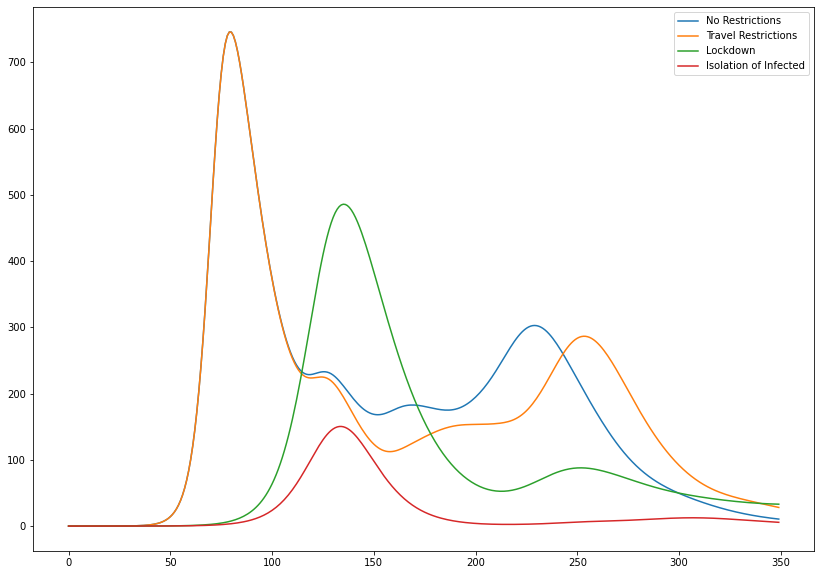

In [174]:
# World total Infected (1/1000000)
print("World")
plt.figure(figsize=(14,10))
plt.plot(x, [np.array([I_lists[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="No Restrictions")
plt.plot(x, [np.array([I_lists_tr[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="Travel Restrictions")
plt.plot(x, [np.array([I_lists_lock[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="Lockdown")
plt.plot(x, [np.array([I_lists_iso[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="Isolation of Infected")
plt.legend()
plt.show()

In [72]:
# Show how isolation restrictions delayed the peak for each country
countries_peak_day_iso = {c: I_lists_iso[c].index(max(I_lists_iso[c])) for c in countries}
countries_peak_delay_iso = {k: countries_peak_day_iso[k]-v for k, v in countries_peak_day.items()}

{k: v for k, v in sorted(countries_peak_delay_iso.items(), key=lambda item: item[1])}

{'Nepal': -184,
 'Vietnam': -150,
 'Iraq': -106,
 'Thailand': -93,
 'Sri Lanka': -89,
 'Philippines': -85,
 'India': -62,
 'Malaysia': -58,
 'Bahrain': -45,
 'Hong Kong': -44,
 'Taiwan': -33,
 'Egypt': -30,
 'Kuwait': -28,
 'Australia': -27,
 'Cambodia': -25,
 'Macau': -11,
 'Russia': -5,
 'Singapore': 1,
 'Japan': 9,
 'China': 54,
 'South Korea': 55,
 'France': 65,
 'Lebanon': 68,
 'United Arab Emirates': 75,
 'Israel': 88,
 'Afghanistan': 88,
 'Spain': 96,
 'Oman': 122,
 'Finland': 126,
 'Belgium': 126,
 'Germany': 141,
 'Italy': 161,
 'United States': 167,
 'United Kingdom': 167,
 'Canada': 180,
 'Iran': 180,
 'Sweden': 196}

# Simulation with antiviral medications
This is modelled by increasing the Gamma coefficient.

In [175]:
# Simulation with travel restrictions
S_lists_antiv = {}
I_lists_antiv = {}
R_lists_antiv = {}

# Initialise lists values
for c in countries:
    S_lists_antiv[c] = [ country_populations[c] ]
    I_lists_antiv[c] = [ confirmed.loc[c, confirmed.columns[0]] ]
    R_lists_antiv[c] = [ deaths.loc[c, deaths.columns[0]] ]
    
# Percentage of infected not isolated
gamma_increase = 0.05
# Days with confirmed cases after which apply lockdown
days_with_cases = 10

# Carry out simulation
for t in range(1, T):
    for c in countries:
        # Get people coming into the country for each compartment
        S_in_t = 0
        I_in_t = 0
        R_in_t = 0
        for n in g.nodes():
            if g.get_edge_data(n, c) is not None:
                n_in_route = g.get_edge_data(n, c)['weight']
                n_total_pop = S_lists_antiv[n][t-1] + I_lists_antiv[n][t-1] + R_lists_antiv[n][t-1]
                n_in_population = n_in_route * np.log10(n_total_pop)
                S_in_t += (S_lists_antiv[n][t-1] / n_total_pop) * n_in_population
                I_in_t += (I_lists_antiv[n][t-1] / n_total_pop) * n_in_population
                R_in_t += (R_lists_antiv[n][t-1] / n_total_pop) * n_in_population
        # Get people going out of the country for each compartment
        current_population = S_lists_antiv[c][t-1] + I_lists_antiv[c][t-1] + R_lists_antiv[c][t-1]
        out_population = out_routes[c] * np.log10(current_population)
        S_out_t = (S_lists_antiv[c][t-1] / current_population) * out_population
        I_out_t = (I_lists_antiv[c][t-1] / current_population) * out_population
        R_out_t = (R_lists_antiv[c][t-1] / current_population) * out_population
    
        current_gamma = country_gammas[c]
        if t >= days_with_cases and I_lists_iso[c][-days_with_cases] > 1:
            current_gamma += gamma_increase
        S_t = S_lists_antiv[c][t-1] - ((S_lists_antiv[c][t-1] / S_lists_antiv[c][0]) * (country_betas[c]*I_lists_antiv[c][t-1]))
        S_lists_antiv[c].append(S_t - S_out_t + S_in_t)
        
        I_t = I_lists_antiv[c][t-1] + ((S_lists_antiv[c][t-1] / S_lists_antiv[c][0]) * (country_betas[c]*I_lists_antiv[c][t-1])) - (I_lists_antiv[c][t-1] * current_gamma)
        I_lists_antiv[c].append(I_t - I_out_t + I_in_t)
        
        R_t = R_lists_antiv[c][t-1] + (I_lists_antiv[c][t-1] * current_gamma)
        R_lists_antiv[c].append(R_t - R_out_t + R_in_t)
        
      

World


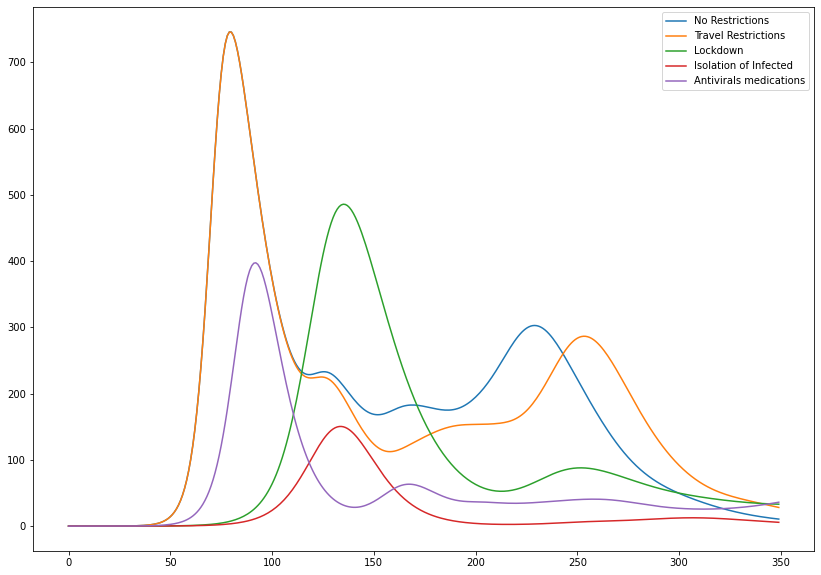

In [176]:
# World total Infected (1/1000000)
print("World")
plt.figure(figsize=(14,10))
plt.plot(x, [np.array([I_lists[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="No Restrictions")
plt.plot(x, [np.array([I_lists_tr[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="Travel Restrictions")
plt.plot(x, [np.array([I_lists_lock[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="Lockdown")
plt.plot(x, [np.array([I_lists_iso[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="Isolation of Infected")
plt.plot(x, [np.array([I_lists_antiv[c][d] for c in countries]).sum()/1000000 for d in range(T)], label="Antivirals medications")
plt.legend()
plt.show()

In [74]:
# Show how isolation restrictions delayed the peak for each country
countries_peak_day_antiv = {c: I_lists_antiv[c].index(max(I_lists_antiv[c])) for c in countries}
countries_peak_delay_antiv = {k: countries_peak_day_antiv[k]-v for k, v in countries_peak_day.items()}

{k: v for k, v in sorted(countries_peak_delay_antiv.items(), key=lambda item: item[1])}

{'Vietnam': -181,
 'Nepal': 11,
 'China': 12,
 'South Korea': 13,
 'Sri Lanka': 21,
 'Israel': 28,
 'Macau': 29,
 'United States': 34,
 'Lebanon': 35,
 'Spain': 40,
 'Sweden': 42,
 'Bahrain': 50,
 'Canada': 52,
 'Iraq': 53,
 'Egypt': 55,
 'Iran': 63,
 'United Kingdom': 64,
 'Kuwait': 66,
 'Germany': 67,
 'Japan': 69,
 'Italy': 72,
 'Finland': 74,
 'Russia': 84,
 'Belgium': 85,
 'Afghanistan': 88,
 'Philippines': 90,
 'Oman': 90,
 'Australia': 98,
 'Thailand': 99,
 'Singapore': 102,
 'Cambodia': 104,
 'United Arab Emirates': 117,
 'India': 121,
 'Taiwan': 126,
 'France': 129,
 'Malaysia': 129,
 'Hong Kong': 145}